# Race Lap Time Prediction - Complete Data Processing Pipeline

## Overview
This notebook contains a comprehensive data processing pipeline for racing telemetry data. It processes raw telemetry files, merges multiple data sources (lap times, analysis data, weather), and creates engineered features for machine learning models.

## Key Components
1. **Data Processing**: Combines telemetry, lap times, analysis, and weather data
2. **Feature Engineering**: Creates lap-level aggregated features from telemetry
3. **Data Validation**: Robust error handling and data quality checks
4. **Output**: Generates parquet files ready for model training

In [ ]:
"""
Data Processing Pipeline for Racing Telemetry Data
==================================================
This module processes raw racing telemetry data from multiple sources and creates
a unified dataset for machine learning model training.

Author: Racing Analytics Team
Date: 2024
"""

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import warnings

# Suppress specific warnings during processing for cleaner output
# Uncomment if needed: warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def parse_any_time_to_seconds(time_value):
    """
    Robust time parsing function that handles multiple time string formats.
    
    This function is critical for handling inconsistent time formats across different
    data sources. It supports:
    - MM:SS.fff format (e.g., "1:23.456")
    - HH:MM:SS format (e.g., "1:23:45")
    - SS.fff format (e.g., "83.456")
    - Direct numeric values (integers or floats)
    
    Parameters
    ----------
    time_value : str, int, float, or NaN
        Time value in various formats
        
    Returns
    -------
    float
        Time in seconds, or np.nan if parsing fails
        
    Examples
    --------
    >>> parse_any_time_to_seconds("1:23.456")
    83.456
    >>> parse_any_time_to_seconds("83.456")
    83.456
    >>> parse_any_time_to_seconds(83.456)
    83.456
    """
    if pd.isna(time_value):
        return np.nan
    
    try:
        # Handle MM:SS.fff format (most common in racing data)
        if isinstance(time_value, str) and ':' in time_value:
            time_parts = time_value.split(':')
            
            # Format: MM:SS.fff
            if len(time_parts) == 2:
                minutes_str, seconds_str = time_parts
                # Use pd.to_numeric with errors='coerce' for robust parsing
                # This handles cases where strings might contain non-numeric characters
                minutes_value = pd.to_numeric(minutes_str, errors='coerce')
                seconds_value = pd.to_numeric(seconds_str, errors='coerce')
                if pd.notna(minutes_value) and pd.notna(seconds_value):
                    return minutes_value * 60 + seconds_value
            
            # Format: HH:MM:SS (for longer durations)
            elif len(time_parts) == 3:
                hours_str, minutes_str, seconds_str = time_parts
                hours_value = pd.to_numeric(hours_str, errors='coerce')
                minutes_value = pd.to_numeric(minutes_str, errors='coerce')
                seconds_value = pd.to_numeric(seconds_str, errors='coerce')
                if pd.notna(hours_value) and pd.notna(minutes_value) and pd.notna(seconds_value):
                    return hours_value * 3600 + minutes_value * 60 + seconds_value
        
        # Handle SS.fff format or direct numeric values
        # This covers cases where time is already in seconds
        numeric_value = pd.to_numeric(time_value, errors='coerce')
        if pd.notna(numeric_value):
            return numeric_value
            
    except Exception:
        # Catch any unexpected errors during parsing and return NaN
        # This ensures the pipeline continues even with malformed data
        pass
    
    return np.nan


def reconstruct_lap_times(lap_data_directory: Path) -> pd.DataFrame:
    """
    Reconstructs lap times from lap start/end files or uses pre-calculated values.
    
    This function handles two scenarios:
    1. If lap_time file contains a 'value' column, use it directly
    2. Otherwise, calculate lap time from timestamp differences between
       lap_start and lap_end files
    
    Parameters
    ----------
    lap_data_directory : Path
        Directory containing lap-related CSV files (lap_start, lap_end, lap_time)
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['vehicle_id', 'lap', 'lap_time_seconds']
        Returns empty DataFrame if required files are missing
    """
    # Search for lap-related files using glob patterns
    lap_start_file_path = next(lap_data_directory.glob("*lap_start*"), None)
    lap_end_file_path = next(lap_data_directory.glob("*lap_end*"), None)
    lap_time_file_path = next(lap_data_directory.glob("*lap_time*"), None)
    
    # Validate that all required files exist
    if not lap_start_file_path or not lap_end_file_path or not lap_time_file_path:
        print(f"⚠️ Missing one or more lap files (start/end/time) in {lap_data_directory.name}. Cannot reconstruct lap times.")
        # Return empty DataFrame with expected schema to maintain consistency
        return pd.DataFrame(columns=['vehicle_id', 'lap', 'lap_time_seconds'])
    
    # Load lap data files
    lap_start_dataframe = pd.read_csv(lap_start_file_path)
    lap_end_dataframe = pd.read_csv(lap_end_file_path)
    lap_time_dataframe = pd.read_csv(lap_time_file_path)
    
    # Prefer pre-calculated lap times if available (more reliable)
    if 'value' in lap_time_dataframe.columns:
        lap_time_labels = lap_time_dataframe[['vehicle_id', 'lap', 'value']].rename(columns={'value': 'lap_time_seconds'})
        # Apply robust parsing to handle various time formats
        lap_time_labels['lap_time_seconds'] = lap_time_labels['lap_time_seconds'].apply(parse_any_time_to_seconds)
        return lap_time_labels

    # Fallback: Calculate lap times from timestamp differences
    print(f"⚠️ No 'value' column found in {lap_data_directory.name}. Reconstructing from lap_start/lap_end timestamps...")
    
    # Convert timestamps to datetime objects for time delta calculation
    lap_start_dataframe['timestamp'] = pd.to_datetime(lap_start_dataframe['timestamp'], errors='coerce')
    lap_end_dataframe['timestamp'] = pd.to_datetime(lap_end_dataframe['timestamp'], errors='coerce')
    
    # Merge start and end timestamps by vehicle_id and lap number
    merged_timestamps = pd.merge(
        lap_start_dataframe[['vehicle_id', 'lap', 'timestamp']],
        lap_end_dataframe[['vehicle_id', 'lap', 'timestamp']],
        on=['vehicle_id', 'lap'],
        suffixes=('_start', '_end')
    )
    
    # Calculate lap time as difference between end and start timestamps
    merged_timestamps['lap_time_seconds'] = (merged_timestamps['timestamp_end'] - merged_timestamps['timestamp_start']).dt.total_seconds()
    
    # Handle cases where calculation might fail (e.g., NaT timestamps)
    # Convert to numeric, coercing any errors to NaN
    merged_timestamps['lap_time_seconds'] = pd.to_numeric(merged_timestamps['lap_time_seconds'], errors='coerce')
    
    lap_time_labels = merged_timestamps[['vehicle_id', 'lap', 'lap_time_seconds']]
    return lap_time_labels


def process_race(race_data_directory: Path) -> pd.DataFrame:
    """
    Main data processing function that combines all data sources for a race session.
    
    This function orchestrates the entire data processing pipeline:
    1. Processes telemetry data (chunked for memory efficiency)
    2. Merges analysis data (sector times, top speed, pit flags)
    3. Adds weather data (air and track temperature)
    4. Engineers features (stint tracking, fuel load proxy)
    5. Merges lap time labels
    
    Parameters
    ----------
    race_data_directory : Path
        Directory containing race data files:
        - *telemetry*.csv: Vehicle telemetry data
        - *AnalysisEnduranceWithSections*.csv: Sector times and analysis
        - *Weather*.csv: Weather conditions
        - *lap_start*.csv, *lap_end*.csv, *lap_time*.csv: Lap timing data
        
    Returns
    -------
    pd.DataFrame
        Combined dataset with lap-level features and labels
        Returns empty DataFrame if critical files are missing
        
    Notes
    -----
    - Uses chunked processing for large telemetry files (200k rows per chunk)
    - Aggregates telemetry to lap level using mean, max, min, std, count
    - Handles missing data gracefully with NaN placeholders
    """
    print(f"\nProcessing {race_data_directory}...")
    
    # ========================================================================
    # STEP 1: TELEMETRY DATA PROCESSING
    # ========================================================================
    # Telemetry files can be very large (millions of rows), so we process
    # them in chunks to avoid memory issues
    
    telemetry_file_path = next(race_data_directory.glob("*telemetry*"), None)
    if telemetry_file_path is None:
        print(f"❌ No telemetry file in {race_data_directory}, skipping...")
        return pd.DataFrame()

    # Chunk size: 200,000 rows per chunk (balance between memory and I/O efficiency)
    chunk_size = 2_000_00
    lap_feature_dataframes = []

    def process_chunk(data_chunk):
        """
        Process a chunk of telemetry data by aggregating to lap level.
        
        For each telemetry signal (speed, throttle, brake, etc.), we calculate:
        - mean: Average value during the lap
        - max: Maximum value (useful for top speed, max throttle)
        - min: Minimum value (useful for braking analysis)
        - std: Standard deviation (measures variability)
        - count: Number of data points (data quality indicator)
        """
        # Remove rows with missing critical fields
        data_chunk = data_chunk.dropna(subset=['telemetry_name', 'telemetry_value', 'lap', 'vehicle_id'])
        
        # Aggregate telemetry signals to lap level
        aggregated_data = (data_chunk
                           .groupby(['vehicle_id', 'lap', 'telemetry_name'])['telemetry_value']
                           .agg(['mean', 'max', 'min', 'std', 'count'])
                           .reset_index())
        return aggregated_data

    # Process telemetry file in chunks
    try:
        csv_reader = pd.read_csv(telemetry_file_path, chunksize=chunk_size)
        # Process each chunk and accumulate results
        # Note: Could add tqdm progress bar: for chunk in tqdm(csv_reader, desc=f"Reading telemetry {race_data_directory.name}"):
        for data_chunk in csv_reader:
            lap_feature_dataframes.append(process_chunk(data_chunk))
    except Exception as e:
        print(f"❌ Error reading telemetry file {telemetry_file_path}: {e}. Skipping race.")
        return pd.DataFrame()

    # Validate that we processed at least some data
    if not lap_feature_dataframes:
        print(f"❌ No telemetry data processed for {race_data_directory.name}. Skipping race.")
        return pd.DataFrame()

    # Combine all chunk results into single DataFrame
    all_aggregated_data = pd.concat(lap_feature_dataframes, ignore_index=True)
    
    # Log telemetry signals found (for debugging and validation)
    unique_telemetry_names = all_aggregated_data['telemetry_name'].unique()
    print(f"Found {len(unique_telemetry_names)} unique telemetry names.")
    
    # ========================================================================
    # STEP 2: PIVOT TELEMETRY TO WIDE FORMAT
    # ========================================================================
    # Transform from long format (one row per telemetry signal) to wide format
    # (one row per lap with columns for each telemetry signal statistic)
    try:
        pivoted_telemetry_df = all_aggregated_data.pivot_table(
            index=['vehicle_id', 'lap'],
            columns='telemetry_name',
            values=['mean', 'max', 'std', 'count', 'min']
        )
        # Flatten multi-level column names: ('mean', 'speed') -> 'mean_speed'
        pivoted_telemetry_df.columns = [f"{statistic}_{name}" for statistic, name in pivoted_telemetry_df.columns]
        pivoted_telemetry_df = pivoted_telemetry_df.reset_index()
    except Exception as e:
        print(f"❌ Error during telemetry pivot for {race_data_directory.name}: {e}. Skipping race.")
        return pd.DataFrame()


    # ========================================================================
    # STEP 3: MERGE CATEGORICAL FEATURES FROM TELEMETRY
    # ========================================================================
    # Extract metadata columns that don't vary within a lap but are important
    # for grouping and analysis (session info, vehicle identifiers)
    try:
        categorical_features_df = pd.read_csv(
            telemetry_file_path,
            usecols=['vehicle_id', 'lap', 'meta_session', 'original_vehicle_id', 'vehicle_number']
        ).drop_duplicates(subset=['vehicle_id', 'lap'])
        pivoted_telemetry_df = pivoted_telemetry_df.merge(categorical_features_df, on=['vehicle_id', 'lap'], how='left')
    except Exception as e:
        print(f"❌ Error merging categorical features for {race_data_directory.name}: {e}.")
        # Continue without these features - model can still work but may lose
        # some predictive power from session/vehicle identifiers

    # ========================================================================
    # STEP 4: MERGE ANALYSIS DATA (SECTOR TIMES, PIT FLAGS, ETC.)
    # ========================================================================
    # Analysis files contain sector times, top speeds, and pit stop indicators
    # These are critical features for lap time prediction
    analysis_dataframe = pd.DataFrame()  # Initialize empty
    analysis_file_path = next(race_data_directory.glob("*AnalysisEnduranceWithSections*"), None)
    
    if analysis_file_path:
        print("   Merging analysis data...")
        try:
            # Base columns needed for merging
            analysis_base_columns = ['NUMBER', 'LAP_NUMBER']
            
            # Dynamically identify time-related columns
            # Read header only to get column names without loading full file
            all_analysis_columns = pd.read_csv(analysis_file_path, sep=';', nrows=0).columns
            time_columns_to_parse = [
                column for column in all_analysis_columns
                if 'SECONDS' in column.upper() or 'TIME' in column.upper() or column in ['S1', 'S2', 'S3']
            ]
            
            # Combine all columns we need
            analysis_columns_to_load = (analysis_base_columns + 
                                        time_columns_to_parse + 
                                        ['TOP_SPEED', 'CROSSING_FINISH_LINE_IN_PIT'])
            # Remove duplicates while preserving order
            analysis_columns_to_load = list(dict.fromkeys(analysis_columns_to_load))
            
            # Read CSV with semicolon separator (common in racing data formats)
            analysis_dataframe = pd.read_csv(
                analysis_file_path, 
                sep=';', 
                skipinitialspace=True, 
                usecols=lambda column: column in analysis_columns_to_load
            )

            # Standardize column names for merging
            analysis_dataframe = analysis_dataframe.rename(columns={
                'NUMBER': 'vehicle_number',
                'LAP_NUMBER': 'lap'
            })

            # Parse all time-related columns using robust parsing function
            # This handles various time formats (MM:SS.fff, SS.fff, numeric) consistently
            print(f"      Parsing time columns: {time_columns_to_parse}")
            for column in time_columns_to_parse:
                if column in analysis_dataframe.columns:
                    # Handle column renaming edge cases
                    target_column_name = ('vehicle_number' if column == 'NUMBER' 
                                          else 'lap' if column == 'LAP_NUMBER' 
                                          else column)
                    # Only parse if column exists after potential renaming
                    if target_column_name in analysis_dataframe.columns:
                        analysis_dataframe[target_column_name] = analysis_dataframe[target_column_name].apply(parse_any_time_to_seconds)

            # Convert numeric columns with error handling
            # TOP_SPEED: Maximum speed achieved during the lap (km/h or mph)
            if 'TOP_SPEED' in analysis_dataframe.columns:
                analysis_dataframe['TOP_SPEED'] = pd.to_numeric(analysis_dataframe['TOP_SPEED'], errors='coerce')
            
            # CROSSING_FINISH_LINE_IN_PIT: Binary flag (1 = pit stop lap, 0 = normal lap)
            if 'CROSSING_FINISH_LINE_IN_PIT' in analysis_dataframe.columns:
                analysis_dataframe['CROSSING_FINISH_LINE_IN_PIT'] = (
                    pd.to_numeric(analysis_dataframe['CROSSING_FINISH_LINE_IN_PIT'], errors='coerce')
                    .fillna(0)
                    .astype(int)
                )

            # Merge analysis data into main DataFrame
            original_dataframe_shape = pivoted_telemetry_df.shape
            
            # Ensure merge keys have compatible data types to avoid merge failures
            # Convert to numeric, coercing any non-numeric values to NaN
            if 'vehicle_number' in pivoted_telemetry_df.columns and 'vehicle_number' in analysis_dataframe.columns:
                pivoted_telemetry_df['vehicle_number'] = pd.to_numeric(pivoted_telemetry_df['vehicle_number'], errors='coerce')
                analysis_dataframe['vehicle_number'] = pd.to_numeric(analysis_dataframe['vehicle_number'], errors='coerce')
            if 'lap' in pivoted_telemetry_df.columns and 'lap' in analysis_dataframe.columns:
                pivoted_telemetry_df['lap'] = pd.to_numeric(pivoted_telemetry_df['lap'], errors='coerce')
                analysis_dataframe['lap'] = pd.to_numeric(analysis_dataframe['lap'], errors='coerce')

            # Select merge columns: keys + all non-key columns from analysis_dataframe
            merge_columns = (['vehicle_number', 'lap'] + 
                            [column for column in analysis_dataframe.columns if column not in ['vehicle_number', 'lap']])
            
            # Left merge: keep all laps from telemetry, add analysis data where available
            pivoted_telemetry_df = pivoted_telemetry_df.merge(analysis_dataframe[merge_columns],
                                                                on=['vehicle_number', 'lap'],
                                                                how='left')
            print(f"   Shape changed from {original_dataframe_shape} to {pivoted_telemetry_df.shape} after merging analysis data.")

        except Exception as e:
            print(f"❌ Error processing analysis data for {race_data_directory.name}: {e}")
            # Add placeholders if merge failed but columns might be expected later
            expected_analysis_columns = ['S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS', 'TOP_SPEED', 'CROSSING_FINISH_LINE_IN_PIT']
            for column in expected_analysis_columns:
                if column not in pivoted_telemetry_df.columns:
                    pivoted_telemetry_df[column] = np.nan
    else:
        print(f"   Missing AnalysisEnduranceWithSections in {race_data_directory}")
        # Add placeholders if file is missing
        expected_analysis_columns = ['S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS', 'TOP_SPEED', 'CROSSING_FINISH_LINE_IN_PIT']
        for column in expected_analysis_columns:
            if column not in pivoted_telemetry_df.columns:
                pivoted_telemetry_df[column] = np.nan


    # ========================================================================
    # STEP 5: FEATURE ENGINEERING - STINT AND FUEL TRACKING
    # ========================================================================
    # These features capture tire degradation and fuel load effects on lap times
    print("   Engineering stint and fuel features...")
    
    if 'CROSSING_FINISH_LINE_IN_PIT' in pivoted_telemetry_df.columns:
        # Create pit flag (1 = pit stop lap, 0 = normal lap)
        pivoted_telemetry_df['pit_flag'] = pivoted_telemetry_df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
        
        # Identify start of new stint (lap after pit stop)
        # Shift pit_flag by 1 to mark the lap AFTER a pit stop
        pivoted_telemetry_df['is_new_stint'] = pivoted_telemetry_df.groupby('vehicle_id')['pit_flag'].shift(1).fillna(0).astype(int)
        
        # Create stint_id: cumulative count of new stints (increments after each pit)
        pivoted_telemetry_df['stint_id'] = pivoted_telemetry_df.groupby('vehicle_id')['is_new_stint'].cumsum()
        
        # Laps on tires: number of laps since last tire change
        # Critical feature: tire degradation significantly affects lap times
        pivoted_telemetry_df['laps_on_tires'] = pivoted_telemetry_df.groupby(['vehicle_id', 'stint_id']).cumcount() + 1
    else:
        print("      Warning: 'CROSSING_FINISH_LINE_IN_PIT' not available. Skipping stint features.")
        pivoted_telemetry_df['laps_on_tires'] = np.nan  # Add placeholder if data unavailable

    # Total laps in session: used for fuel load proxy calculation
    pivoted_telemetry_df['total_laps_session'] = pivoted_telemetry_df.groupby('vehicle_id')['lap'].transform('max')
    
    # Fuel load proxy: estimated fuel remaining (higher = more fuel = slower lap times)
    # Assumes fuel decreases linearly with lap number
    pivoted_telemetry_df['fuel_load_proxy'] = pivoted_telemetry_df['total_laps_session'] - pivoted_telemetry_df['lap']

    # ========================================================================
    # STEP 6: MERGE WEATHER DATA
    # ========================================================================
    # Weather conditions affect tire grip and engine performance
    # Air temperature and track temperature are averaged across the session
    weather_dataframe = pd.DataFrame()  # Initialize
    weather_file_path = next(race_data_directory.glob("*Weather*"), None)
    
    if weather_file_path:
        print("   Merging weather data...")
        try:
            weather_dataframe = pd.read_csv(weather_file_path, sep=';')
            # Use session averages (weather typically doesn't vary much within a race)
            pivoted_telemetry_df['session_air_temp'] = pd.to_numeric(weather_dataframe['AIR_TEMP'], errors='coerce').mean()
            pivoted_telemetry_df['session_track_temp'] = pd.to_numeric(weather_dataframe['TRACK_TEMP'], errors='coerce').mean()
        except Exception as e:
            print(f"   Error processing weather data: {e}. Setting to NaN.")
            pivoted_telemetry_df['session_air_temp'] = np.nan
            pivoted_telemetry_df['session_track_temp'] = np.nan
    else:
        print(f"   Missing Weather in {race_data_directory}. Setting to NaN.")
        pivoted_telemetry_df['session_air_temp'] = np.nan
        pivoted_telemetry_df['session_track_temp'] = np.nan


    # ========================================================================
    # STEP 7: MERGE LAP TIME LABELS (TARGET VARIABLE)
    # ========================================================================
    # Lap times are the target variable for our predictive models
    print("   Adding lap time labels...")
    try:
        # Reconstruct lap times from lap files (handles multiple formats)
        lap_time_labels = reconstruct_lap_times(race_data_directory)
        
        # Ensure merge keys have compatible data types
        # vehicle_id: convert to string for consistent merging
        if 'vehicle_id' in pivoted_telemetry_df.columns and 'vehicle_id' in lap_time_labels.columns:
            pivoted_telemetry_df['vehicle_id'] = pivoted_telemetry_df['vehicle_id'].astype(str)
            lap_time_labels['vehicle_id'] = lap_time_labels['vehicle_id'].astype(str)
        
        # lap: convert to numeric
        if 'lap' in pivoted_telemetry_df.columns and 'lap' in lap_time_labels.columns:
            pivoted_telemetry_df['lap'] = pd.to_numeric(pivoted_telemetry_df['lap'], errors='coerce')
            lap_time_labels['lap'] = pd.to_numeric(lap_time_labels['lap'], errors='coerce')

        # Merge lap times as target variable
        final_dataframe = pivoted_telemetry_df.merge(lap_time_labels[['vehicle_id', 'lap', 'lap_time_seconds']],
                                                      on=['vehicle_id', 'lap'],
                                                      how='left')
    except Exception as e:
        print(f"❌ Error merging lap time labels for {race_data_directory.name}: {e}. Skipping race.")
        return pd.DataFrame()
    
    # Add metadata columns for tracking and filtering
    final_dataframe['race_session'] = race_data_directory.name  # e.g., "Race 1", "Race 2"
    final_dataframe['track'] = race_data_directory.parent.name  # e.g., "Road America", "COTA"
    
    # Drop track column if not needed (uncomment if track is redundant)
    final_dataframe = final_dataframe.drop('track', axis=1)

    print(f"✅ Finished {race_data_directory.name}: {final_dataframe.shape}")
    return final_dataframe


# ========================================================================
# MAIN EXECUTION - PROCESS MULTIPLE RACE SESSIONS
# ========================================================================
# This section processes multiple race sessions and combines them into
# a single dataset for model training

# Define base path (adjust if script is located elsewhere)
# Expected directory structure: ./track-name/Track Name/Race N/
base_directory_path = Path(".")  # Current directory

# List of race sessions to process
# Uncomment/add tracks as needed for your analysis
race_directory_paths = [
    # "road-america/Road America/Race 1",
    # "road-america/Road America/Race 2",
    # "circuit-of-the-americas/COTA/Race 1",
    # "circuit-of-the-americas/COTA/Race 2",
    # "barber-motorsports-park/barber/Race 1",
    # "barber-motorsports-park/barber/Race 2",
    # "sebring/Sebring/Race 1",
    # "sebring/Sebring/Race 2",
    # "sonoma/Sonoma/Race 1",
    # "sonoma/Sonoma/Race 2",
    "virginia-international-raceway/VIR/Race 1",
    "virginia-international-raceway/VIR/Race 2",
]

# Process each race session
all_dataframes = []
for race_path_string in race_directory_paths:
    # Construct absolute path from script location
    race_data_path = base_directory_path / race_path_string
    
    if race_data_path.exists():
        # Process race data (telemetry, analysis, weather, lap times)
        race_dataframe = process_race(race_data_path)
        
        # Only append non-empty DataFrames
        if not race_dataframe.empty:
            all_dataframes.append(race_dataframe)
    else:
        print(f"⚠️ Directory not found: {race_data_path}, skipping.")

# ========================================================================
# COMBINE AND SAVE FINAL DATASET
# ========================================================================
if all_dataframes:
    # Concatenate all race DataFrames into single dataset
    combined_dataframe = pd.concat(all_dataframes, ignore_index=True)
    print(f"\n✅ Combined dataset shape: {combined_dataframe.shape}")

    # Data type optimization: convert object columns to numeric where possible
    # This reduces memory usage and ensures compatibility with ML models
    print("\nChecking final data types before saving...")
    for column in combined_dataframe.select_dtypes(include=['object']).columns:
        # Exclude known categorical/ID columns that should remain as objects
        if column not in ['vehicle_id', 'meta_session', 'original_vehicle_id', 'track']:
            try:
                # Attempt conversion to numeric (coerces errors to NaN)
                combined_dataframe[column] = pd.to_numeric(combined_dataframe[column], errors='coerce')
                print(f"   Converted '{column}' to numeric.")
            except Exception:
                print(f"   Could not convert '{column}' to numeric, keeping as object.")

    # Display final DataFrame info for validation
    print("\nFinal DataFrame Info:")
    combined_dataframe.info()

    # Save to Parquet format (efficient binary format for large datasets)
    try:
        output_file_path = "virginia-international-raceway_all_races_lap_features.parquet"
        combined_dataframe.to_parquet(output_file_path, index=False)
        print(f"\n✅ Successfully saved combined data to {output_file_path}")
    except Exception as e:
        print(f"\n❌ Error saving final Parquet file: {e}")
        print("   Inspect the DataFrame info above for problematic columns (often 'object' type).")
else:
    print("\n❌ No data processed. Parquet file not saved.")


Processing virginia-international-raceway\VIR\Race 1...
Found 9 unique telemetry names.
   Merging analysis data...
      Parsing time columns: [' LAP_TIME', 'PIT_TIME', 'S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS', 'IM1a_time', 'IM1_time', 'IM2a_time', 'IM2_time', 'IM3a_time', 'FL_time']
   Shape changed from (417, 50) to (417, 62) after merging analysis data.
   Engineering stint and fuel features...
   Merging weather data...
   Adding lap time labels...
✅ Finished Race 1: (472, 72)

Processing virginia-international-raceway\VIR\Race 2...
Found 9 unique telemetry names.
   Merging analysis data...
      Parsing time columns: [' LAP_TIME', 'PIT_TIME', 'S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS', 'IM1a_time', 'IM1_time', 'IM2a_time', 'IM2_time', 'IM3a_time', 'FL_time']
   Shape changed from (440, 50) to (440, 62) after merging analysis data.
   Engineering stint and fuel features...
   Merging weather data...
   Adding lap time labels...
✅ Finished Race 2: (495, 72)

✅ Combined dataset shap

## Model Training - Lap Time Prediction

This section trains machine learning models to predict lap times based on telemetry data, sector times, and engineered features.

### Model Architecture
- **Algorithm**: Random Forest Regressor (ensemble of decision trees)
- **Target**: Lap time in seconds (log-transformed for better distribution)
- **Features**: 
  - Telemetry aggregates (mean, max, std, count)
  - Sector times (S1, S2, S3)
  - Engineered features (laps on tires, fuel load proxy)
  - Weather conditions
  - Categorical features (vehicle ID, session info)

Loaded shape: (5958, 95)
Shape after dropping NaNs in target: (5665, 95)
Shape before outlier filtering: (5665, 95)
Shape after outlier filtering: (3881, 95)
Starting feature engineering...
✅ Using 88 numeric features.
✅ Using 6 categorical features: ['meta_session', 'original_vehicle_id', 'vehicle_number', 'vehicle_id', 'race_session', 'track']
Train shape: (3104, 94), Test shape: (777, 94)

🔍 Starting Grid Search with 16 combinations...


Grid Search Progress: 100%|████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.79s/it]



✅ Best parameters:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
🏁 Best CV MSE (log scale): 0.0043
📊 Final RMSE (log scale): 0.0601
📊 RMSE (seconds): 11.29
📊 R² (seconds): 0.8917

Top 15 Feature Importances:
num__mean_speed            0.141492
num__S2_SECONDS            0.100682
num__std_accy_can          0.098541
cat__track_Sonoma          0.096037
num__mean_ath              0.044978
num__mean_nmot             0.037672
num__last_lap_time         0.034205
num__total_laps_session    0.029946
num__IM3a_time             0.024782
num__session_air_temp      0.020498
num__S3_SECONDS            0.019893
num__count_gear            0.019544
num__count_pbrake_r        0.019179
num__count_pbrake_f        0.018563
num__std_pbrake_r          0.017150
dtype: float64
✅ Plot saved: final_model_true_vs_predicted_laps.png

--- True Lap Times ---
count    777.000000
mean     148.284185
std      

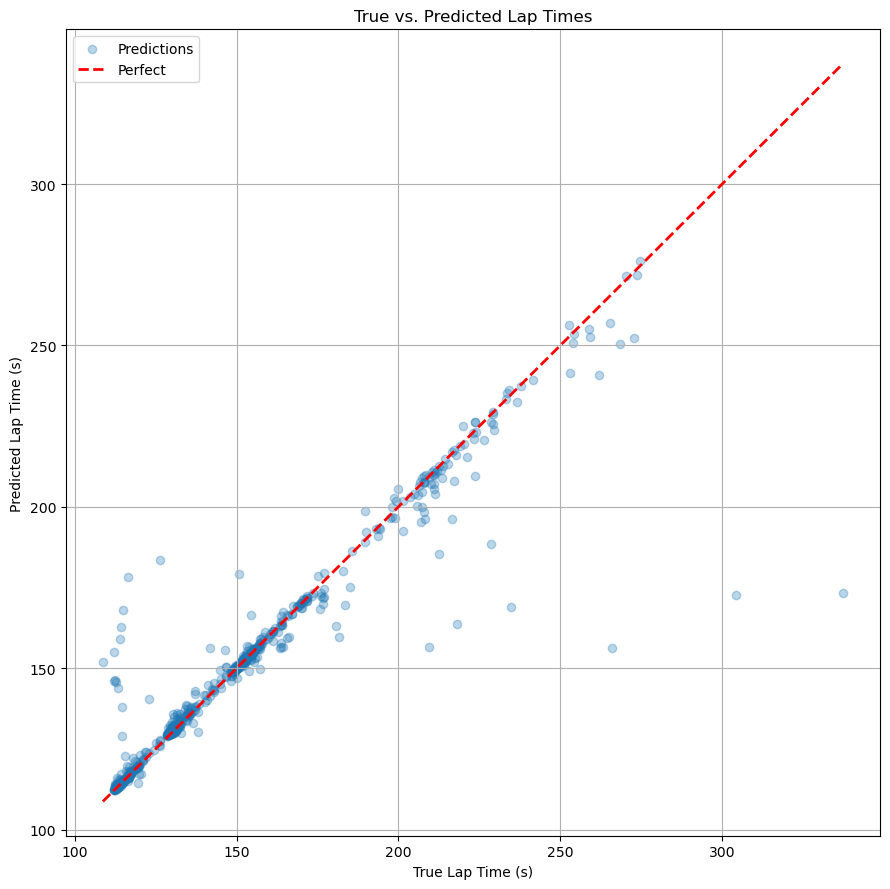

In [ ]:
"""
Machine Learning Model Training Pipeline
========================================
This script trains a Random Forest model to predict lap times from telemetry
and analysis data. Uses log-transformed target for better distribution.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for cleaner output during training
warnings.filterwarnings('ignore')

# ========================================================================
# STEP 1: LOAD DATA
# ========================================================================
try:
    lap_data_dataframe = pd.read_parquet("all_races_lap_features.parquet")
    print(f"Loaded shape: {lap_data_dataframe.shape}")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Ensure 'all_races_lap_features.parquet' is in the correct location.")
    exit()

# Remove rows without target variable (cannot train without labels)
lap_data_dataframe = lap_data_dataframe.dropna(subset=["lap_time_seconds"])
print(f"Shape after dropping NaNs in target: {lap_data_dataframe.shape}")

# ========================================================================
# STEP 2: TARGET VARIABLE PREPROCESSING AND OUTLIER REMOVAL
# ========================================================================
target_variable_name = "lap_time_seconds"

# Convert lap times from milliseconds to seconds (if needed)
# Check if values are in milliseconds (> 1000) or already in seconds
lap_data_dataframe[target_variable_name] = lap_data_dataframe["lap_time_seconds"] / 1000.0

# Remove outliers: unrealistic lap times indicate data errors
# Lower bound: minimum physically possible lap time (e.g., 1:40 = 100 seconds)
# Upper bound: keep pit stop laps but remove extreme outliers
print(f"Shape before outlier filtering: {lap_data_dataframe.shape}")
min_time_threshold = 100   # Minimum reasonable lap time (seconds)
max_time_threshold = 450   # Maximum reasonable lap time (includes pit stops)
lap_data_dataframe = lap_data_dataframe[
    (lap_data_dataframe[target_variable_name] >= min_time_threshold) & 
    (lap_data_dataframe[target_variable_name] <= max_time_threshold)
].copy()
print(f"Shape after outlier filtering: {lap_data_dataframe.shape}")

if lap_data_dataframe.empty:
    print("Error: No data remaining after outlier filtering. Check thresholds.")
    exit()

# ========================================================================
# STEP 3: FEATURE ENGINEERING
# ========================================================================
print("Starting feature engineering...")

# Sort by vehicle and lap to enable lag features
lap_data_dataframe = lap_data_dataframe.sort_values(by=["vehicle_id", "lap"])

# Create lag feature: previous lap time (strong predictor)
# This captures driver consistency and track evolution
lap_data_dataframe["last_lap_time"] = lap_data_dataframe.groupby("vehicle_id")[target_variable_name].shift(1)

# ========================================================================
# STEP 4: PREPARE FEATURES AND TARGET
# ========================================================================
# Separate features (X) from target (y)
# Drop lap number (index, not a feature) and target variable
feature_matrix = lap_data_dataframe.drop(columns=["lap", target_variable_name])

# Log-transform target for better distribution
# log1p = log(1+x) handles zeros gracefully and normalizes skewed data
# This improves model performance on highly skewed lap time distributions
target_vector = np.log1p(lap_data_dataframe[target_variable_name])


# ========================================================================
# STEP 5: IDENTIFY FEATURE TYPES
# ========================================================================
# Separate features into categorical and numeric for different preprocessing

# Categorical features: require one-hot encoding
# These represent discrete categories (vehicle IDs, session types, etc.)
categorical_column_names = [
    "meta_session",           # Race session identifier
    "original_vehicle_id",    # Original vehicle identifier
    "vehicle_number",         # Vehicle number
    "vehicle_id",             # Vehicle ID
    "race_session",           # Race session name
    "track"                   # Track name
    # Note: CROSSING_FINISH_LINE_IN_PIT kept as numeric (0/1 binary)
]

# Filter to only include columns that actually exist in the dataset
available_categorical_columns = [column for column in categorical_column_names if column in feature_matrix.columns]

# All remaining columns that are numeric
# Includes: telemetry aggregates, sector times, engineered features, etc.
numeric_column_names = [
    column for column in feature_matrix.columns
    if column not in available_categorical_columns and pd.api.types.is_numeric_dtype(feature_matrix[column])
]

print(f"✅ Using {len(numeric_column_names)} numeric features.")
print(f"✅ Using {len(available_categorical_columns)} categorical features: {available_categorical_columns}")

# ========================================================================
# STEP 6: TRAIN/TEST SPLIT
# ========================================================================
# Split data into training (80%) and testing (20%) sets
# Random split with fixed seed for reproducibility
train_features, test_features, train_target, test_target = train_test_split(
    feature_matrix, target_vector, test_size=0.2, random_state=42
)
print(f"Train shape: {train_features.shape}, Test shape: {test_features.shape}")

# ========================================================================
# STEP 7: PREPROCESSING PIPELINE
# ========================================================================
# Create preprocessing pipelines for numeric and categorical features
# These are combined using ColumnTransformer

# Numeric feature preprocessing:
# 1. Imputation: Fill missing values with mean (robust to outliers)
# 2. Scaling: Standardize to zero mean, unit variance
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical feature preprocessing:
# 1. Imputation: Fill missing values with 'missing' string
# 2. One-hot encoding: Convert categories to binary vectors
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    # sparse_output=False: Return dense arrays (required for Random Forest)
])

# Combine numeric and categorical transformers
# remainder='passthrough': Keep any unhandled columns (should be none)
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_column_names),
        ('cat', categorical_transformer, available_categorical_columns)
    ],
    remainder='passthrough'
)

# Full pipeline: preprocessing + model
# This ensures preprocessing is applied consistently during training and prediction
model_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# ========================================================================
# STEP 8: HYPERPARAMETER TUNING
# ========================================================================
# Define hyperparameter grid for grid search
# These parameters control model complexity and generalization

hyperparameter_grid = {
    "model__n_estimators": [300],        # Number of trees (more = better but slower)
    "model__max_depth": [10, 20],        # Maximum tree depth (controls overfitting)
    "model__max_features": [0.3, 0.5],   # Features per split (reduces overfitting)
    "model__min_samples_split": [2, 5], # Minimum samples to split node
    "model__min_samples_leaf": [1, 2],   # Minimum samples in leaf node
    "model__bootstrap": [True],           # Bootstrap sampling
    "model__criterion": ["squared_error"] # Splitting criterion
}

# ========================================================================
# STEP 9: GRID SEARCH WITH CROSS-VALIDATION
# ========================================================================
# Use GroupKFold to prevent data leakage: ensure same vehicle doesn't appear
# in both training and validation sets (important for time series data)

parameter_combinations = list(ParameterGrid(hyperparameter_grid))
grid_search_results = []
print(f"\n🔍 Starting Grid Search with {len(parameter_combinations)} combinations...")

try:
    # Group by vehicle_id to prevent leakage
    # Same vehicle's laps should stay together in train/val splits
    vehicle_groups = (train_features["vehicle_id"] if "vehicle_id" in train_features.columns 
                      else pd.Series(["unknown"] * len(train_features)))
    
    # Use GroupKFold with appropriate number of splits
    number_of_splits = min(3, vehicle_groups.nunique())
    if number_of_splits < 2:
        raise ValueError("Not enough unique vehicle groups for GroupKFold.")

    cross_validator = GroupKFold(n_splits=number_of_splits)

    # Evaluate each parameter combination using cross-validation
    for parameter_set in tqdm(parameter_combinations, desc="Grid Search Progress"):
        model_pipeline.set_params(**parameter_set)
        cross_validation_scores = cross_val_score(
            model_pipeline,
            train_features,
            train_target,
            scoring="neg_mean_squared_error",  # Negative MSE (higher is better)
            cv=cross_validator.split(train_features, train_target, vehicle_groups),
            n_jobs=-1  # Use all available CPU cores
        )
        mean_mse = -np.mean(cross_validation_scores)  # Convert back to positive MSE
        grid_search_results.append((parameter_set, mean_mse))

    # Select best parameters (lowest MSE)
    best_hyperparameters, best_cv_mse = min(grid_search_results, key=lambda x: x[1])
except Exception as e:
    print(f"⚠️ GroupKFold error: {e}")
    # Fallback to default parameters if CV fails
    best_hyperparameters = {
        "model__n_estimators": 300, 
        "model__max_depth": 15, 
        "model__min_samples_leaf": 4
    }
    best_cv_mse = float('inf')

# ========================================================================
# STEP 10: TRAIN FINAL MODEL
# ========================================================================
# Train model with best hyperparameters on full training set
print("\n✅ Best parameters:")
print({key.replace('model__', ''): value for key, value in best_hyperparameters.items()})
print(f"🏁 Best CV MSE (log scale): {best_cv_mse:.4f}")

# Set best parameters and train on full training set
model_pipeline.set_params(**best_hyperparameters)
model_pipeline.fit(train_features, train_target)

# ========================================================================
# STEP 11: MODEL EVALUATION
# ========================================================================
# Evaluate model on held-out test set

# Predict on test set (predictions are in log space)
predicted_log_target = model_pipeline.predict(test_features)
test_rmse_log_scale = mean_squared_error(test_target, predicted_log_target, squared=False)
print(f"📊 Final RMSE (log scale): {test_rmse_log_scale:.4f}")

# Convert predictions back to seconds using inverse log transform
# expm1(x) = exp(x) - 1, inverse of log1p
predicted_seconds = np.expm1(predicted_log_target)
actual_seconds = np.expm1(test_target)

# Remove any infinite values that may result from transformation
finite_mask = np.isfinite(predicted_seconds) & np.isfinite(actual_seconds)
predicted_seconds, actual_seconds = predicted_seconds[finite_mask], actual_seconds[finite_mask]

# Calculate metrics in original scale (seconds)
rmse_seconds = mean_squared_error(actual_seconds, predicted_seconds, squared=False)
r2_score_seconds = r2_score(actual_seconds, predicted_seconds)
print(f"📊 RMSE (seconds): {rmse_seconds:.2f}")
print(f"📊 R² (seconds): {r2_score_seconds:.4f}")

# ========================================================================
# STEP 12: FEATURE IMPORTANCE ANALYSIS
# ========================================================================
# Analyze which features contribute most to predictions
# Helps understand model behavior and identify key factors affecting lap times
try:
    # Get feature names after preprocessing (includes one-hot encoded names)
    processed_feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Extract feature importances from trained Random Forest model
    feature_importances = model_pipeline.named_steps['model'].feature_importances_
    
    # Create sorted Series for easy inspection
    feature_importance_series = pd.Series(feature_importances, index=processed_feature_names).sort_values(ascending=False)
    print("\nTop 15 Feature Importances:")
    print(feature_importance_series.head(15))
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

# ========================================================================
# STEP 13: VISUALIZATION
# ========================================================================
# Create scatter plot of predictions vs. actual values
# Perfect predictions would lie on the red diagonal line

plt.figure(figsize=(9, 9))
plt.scatter(actual_seconds, predicted_seconds, alpha=0.3, label='Predictions')
plt.plot([actual_seconds.min(), actual_seconds.max()],
         [actual_seconds.min(), actual_seconds.max()], 'r--', lw=2, label='Perfect')
plt.xlabel("True Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("True vs. Predicted Lap Times")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio for better visual assessment
plt.tight_layout()
plt.savefig("final_model_true_vs_predicted_laps.png", dpi=150)
print("✅ Plot saved: final_model_true_vs_predicted_laps.png")

# ========================================================================
# STEP 14: STATISTICAL SUMMARY
# ========================================================================
# Compare distributions of true and predicted lap times
# Helps identify systematic biases or prediction errors
print("\n--- True Lap Times (Test Set) ---")
print(pd.Series(actual_seconds).describe())
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(predicted_seconds).describe())

In [ ]:
param_grid = {
    "model__n_estimators": [300],                 # 100, 300, 500
    "model__max_depth": [10, 20],  # 1, 2, 3, 4, 5, 10, 20, 40, None
    "model__max_features": [0.3, 0.5],     # "sqrt", "log2", 0.3, 0.5
    "model__min_samples_split": [2, 5],          # 2, 5, 10
    "model__min_samples_leaf": [1, 2],            # 1, 2, 4, 8
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}

param_grid = {
    "model__n_estimators": [100, 300, 500],                 # 100, 300, 500
    "model__max_depth": [1, 2, 3, 4, 5, 10, 20, 40, None],  # 1, 2, 3, 4, 5, 10, 20, 40, None
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],     # "sqrt", "log2", 0.3, 0.5
    "model__min_samples_split": [2, 5,10],          # 2, 5, 10
    "model__min_samples_leaf": [1, 2,4,8],            # 1, 2, 4, 8
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}

# Road America Model

## Hyperparameter Testing

Loaded shape: (664, 72)
Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.
Shape before outlier filtering: (613, 77)
min_time_thresh:  110
max_time_thresh:  290
Shape after outlier filtering: (535, 77)
✅ Using 69 numeric features.
✅ Using 5 categorical features: ['meta_session', 'original_vehicle_id', 'vehicle_number', 'vehicle_id', 'race_session']
Train shape: (428, 74), Test shape: (107, 74)

🔍 Starting Grid Search with 1296 combinations...
Using GroupKFold with 3 splits.


Grid Search Progress: 100%|████████████████████████████████████████████████████████| 1296/1296 [09:07<00:00,  2.37it/s]



✅ Best parameters:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🏁 Best CV MSE (log scale): 0.000413

📊 Final RMSE (log scale): 0.0122
📊 RMSE (seconds): 2.47
📊 R² (seconds): 0.9935

Top 20 Feature Importances:
num__mean_speed              0.241098
num__mean_ath                0.228238
num__mean_nmot               0.164993
num__max_speed               0.121770
num__mean_pbrake_r           0.038107
num__std_pbrake_r            0.032478
num__min_nmot                0.014148
num__session_air_temp        0.013773
num__session_track_temp      0.012092
cat__meta_session_R1         0.011556
num__count_accy_can          0.010473
num__mean_pbrake_f           0.010156
cat__meta_session_R2         0.009646
num__std_speed               0.009279
num__mean_gear               0.008177
num__std_pbrake_f            0.007743
num__total_laps_session      0.007171
num__fuel_load_proxy         0.00

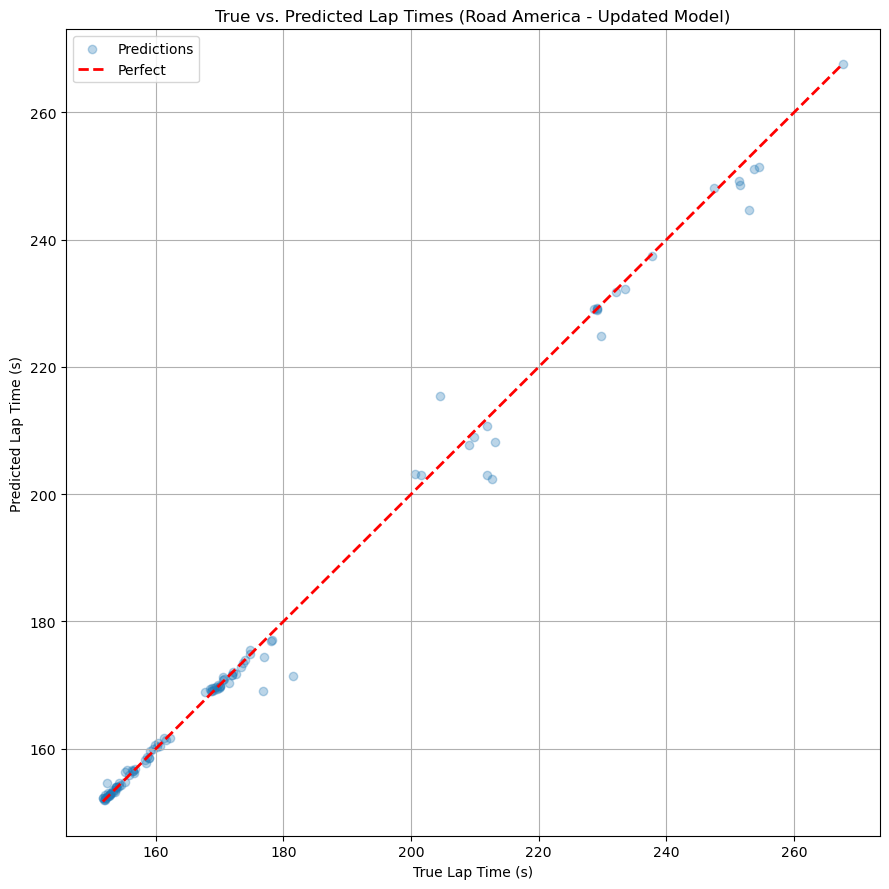

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load lap-level dataset ---
try:
    df = pd.read_parquet("road-america_all_races_lap_features.parquet")
    print(f"Loaded shape: {df.shape}")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Ensure 'road-america_all_races_lap_features.parquet' is in the correct location.")
    exit() # Exit if file can't be loaded


# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
# Rename 'is_new_stint' to 'is_out_lap' for clarity (it marks the lap *after* a pit)
# Ensure it exists, fillna if not (though it should from process_race)
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)

# Get the in-pit flag (lap *entering* the pits)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)

# Define a 'normal' lap (not pitting, not leaving pits)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)

# Get the lap time only for normal laps, else NaN
#df['normal_lap_time'] = df[target].where(df['is_normal_lap'])
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))


# Forward-fill the last known normal lap time, then shift
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)

# Create a rolling average of the last 3 *normal* laps
# .reset_index(0, drop=True) is needed after a groupby().rolling()
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)

print("Advanced features created.")
# --- END NEW FEATURES ---


# --- 3. Define target, filter outliers, and define features (X) ---

# Filter outliers based on the original seconds scale *after* FE
print(f"Shape before outlier filtering: {df.shape}")
min_time_thresh = 110
max_time_thresh = 290 
print('min_time_thresh: ', min_time_thresh)
print('max_time_thresh: ', max_time_thresh)
df = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy() # Use .copy()
print(f"Shape after outlier filtering: {df.shape}")

if df.empty:
    print("Error: No data remaining after outlier filtering. Check thresholds.")
    exit()

# Keep all features except lap index, the target, and intermediate columns
# The simple "last_lap_time" is no longer needed as we have better features
drop_cols = ["lap", target, 'normal_lap_time', 'last_lap_time']
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = np.log1p(df[target]) # Log transform the target


# --- 4. Identify feature types ---
categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

# Filter for columns that exist (safety)
existing_categorical_cols = [col for col in categorical_cols if col in X.columns]

# All others that are numeric
# This will now *automatically* include your new features:
# 'is_out_lap', 'pit_flag', 'is_normal_lap', 'last_normal_lap_time', 'rolling_3_normal_lap_avg'
numeric_cols = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]

print(f"✅ Using {len(numeric_cols)} numeric features.")
print(f"✅ Using {len(existing_categorical_cols)} categorical features: {existing_categorical_cols}")


# --- 5. Train/Test Split ---
# Note: X_masked and y_masked are no longer needed as we filtered 'df' directly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


# --- 6. Preprocessing and Model Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # 'mean' is fine, 'median' is also robust
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols), # Apply to numeric
        ('cat', categorical_transformer, existing_categorical_cols)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    #("model", LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1))
])

# --- 7. Define Hyperparameter Grid ---
# Using a slightly smaller, more focused grid based on your last results
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [300],
    "model__max_depth": [20],
    "model__max_features": [0.3, 0.5, "sqrt"],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [2],
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [100, 300, 500],                 # 100, 300, 500
    "model__max_depth": [1, 2, 3, 4, 5, 10, 20, 40, None],  # 1, 2, 3, 4, 5, 10, 20, 40, None
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],     # "sqrt", "log2", 0.3, 0.5
    "model__min_samples_split": [2, 5,10],          # 2, 5, 10
    "model__min_samples_leaf": [1, 2,4,8],            # 1, 2, 4, 8
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}
'''
param_grid = { #for LGBMRegressor
    "model__n_estimators": [300, 500],
    "model__learning_rate": [0.05, 0.1],     # How fast the model learns
    "model__num_leaves": [20, 31, 40],       # Key tuning parameter
    "model__max_depth": [20, -1],            # -1 means no limit
    "model__reg_alpha": [0, 0.1],            # L1 regularization
    "model__reg_lambda": [0, 0.1]            # L2 regularization
}
'''

# --- 8. Manual Grid Search with GroupKFold ---
param_combos = list(ParameterGrid(param_grid))
results = []
print(f"\n🔍 Starting Grid Search with {len(param_combos)} combinations...")

try:
    groups = X_train["vehicle_id"] if "vehicle_id" in X_train.columns else pd.Series(["unknown"] * len(X_train))
    # Ensure at least 3 unique groups for 3 splits, fallback to 2
    n_unique_groups = groups.nunique()
    n_splits = min(3, n_unique_groups)
    
    if n_splits < 2:
        print(f"⚠️ Only {n_unique_groups} unique group(s). Falling back to standard 3-fold CV (no grouping).")
        cv_split_method = 3
    else:
        print(f"Using GroupKFold with {n_splits} splits.")
        cv = GroupKFold(n_splits=n_splits)
        cv_split_method = list(cv.split(X_train, y_train, groups))

    for params in tqdm(param_combos, desc="Grid Search Progress"):
        full_pipeline.set_params(**params)
        scores = cross_val_score(
            full_pipeline,
            X_train,
            y_train,
            scoring="neg_mean_squared_error",
            cv=cv_split_method, # Use the defined split method
            n_jobs=-1
        )
        mean_mse = -np.mean(scores)
        results.append((params, mean_mse))

    best_params, best_mse = min(results, key=lambda x: x[1])
except Exception as e:
    print(f"⚠️ CV error: {e}. Defaulting to base parameters.")
    # Fallback parameters if grid search fails completely
    best_params = {
        "model__n_estimators": 300, 
        "model__max_depth": 20, 
        "model__min_samples_leaf": 2,
        "model__max_features": 0.3,
        "model__min_samples_split": 2,
        "model__bootstrap": True,
        "model__criterion": "squared_error"
    }
    best_mse = float('inf')

# --- 9. Final Training ---
print("\n✅ Best parameters:")
print({k.replace('model__', ''): v for k, v in best_params.items()})
print(f"🏁 Best CV MSE (log scale): {best_mse:.6f}") # More precision

full_pipeline.set_params(**best_params)
full_pipeline.fit(X_train, y_train)

# --- 10. Evaluate on test set ---
y_pred_log = full_pipeline.predict(X_test)
final_rmse_log = mean_squared_error(y_test, y_pred_log, squared=False)
print(f"\n📊 Final RMSE (log scale): {final_rmse_log:.4f}")

# Convert back to seconds
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

# Mask any potential inf/-inf from expm1
mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
print(f"📊 R² (seconds): {r2_sec:.4f}")

# --- 11. Feature Importances ---
try:
    feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = full_pipeline.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop 20 Feature Importances:")
    print(fi.head(20))
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

# --- 12. Visualization ---
plt.figure(figsize=(9, 9))
plt.scatter(y_test_sec, y_pred_sec, alpha=0.3, label='Predictions')
plt.plot([min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())],
         [min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())], 'r--', lw=2, label='Perfect')
plt.xlabel("True Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("True vs. Predicted Lap Times (Road America - Updated Model)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
#plt.savefig("road-america_model_true_vs_predicted_laps_final.png")
#print("✅ Plot saved: road-america_model_true_vs_predicted_laps_final.png")

# --- 13. Stats Comparison ---
print("\n--- True Lap Times (Test Set) ---")
print(pd.Series(y_test_sec).describe())
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

## Finding right interval

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 300
Shape after outlier filtering: (536, 77)


  7%|█████▌                                                                             | 1/15 [00:00<00:04,  2.82it/s]

📊 RMSE (seconds): 6.02
📊 R² (seconds): 0.9673

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 290
Shape after outlier filtering: (535, 77)


 13%|███████████                                                                        | 2/15 [00:00<00:04,  2.89it/s]

📊 RMSE (seconds): 3.42
📊 R² (seconds): 0.9875

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 280
Shape after outlier filtering: (535, 77)


 20%|████████████████▌                                                                  | 3/15 [00:01<00:04,  2.90it/s]

📊 RMSE (seconds): 3.42
📊 R² (seconds): 0.9875

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 270
Shape after outlier filtering: (527, 77)


 27%|██████████████████████▏                                                            | 4/15 [00:01<00:03,  2.91it/s]

📊 RMSE (seconds): 3.12
📊 R² (seconds): 0.9912

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 260
Shape after outlier filtering: (516, 77)


 33%|███████████████████████████▋                                                       | 5/15 [00:01<00:03,  2.91it/s]

📊 RMSE (seconds): 4.14
📊 R² (seconds): 0.9806

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 250
Shape after outlier filtering: (506, 77)


 40%|█████████████████████████████████▏                                                 | 6/15 [00:02<00:03,  2.92it/s]

📊 RMSE (seconds): 6.17
📊 R² (seconds): 0.9467

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 240
Shape after outlier filtering: (492, 77)


 47%|██████████████████████████████████████▋                                            | 7/15 [00:02<00:02,  2.92it/s]

📊 RMSE (seconds): 5.99
📊 R² (seconds): 0.9029

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 230
Shape after outlier filtering: (475, 77)


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:02<00:02,  2.92it/s]

📊 RMSE (seconds): 6.14
📊 R² (seconds): 0.9035

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 220
Shape after outlier filtering: (460, 77)


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:03<00:02,  2.93it/s]

📊 RMSE (seconds): 2.29
📊 R² (seconds): 0.9770

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 210
Shape after outlier filtering: (450, 77)


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:03<00:01,  2.94it/s]

📊 RMSE (seconds): 1.10
📊 R² (seconds): 0.9896

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 200
Shape after outlier filtering: (435, 77)


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:03<00:01,  2.98it/s]

📊 RMSE (seconds): 2.56
📊 R² (seconds): 0.9206

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 190
Shape after outlier filtering: (431, 77)


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:04<00:01,  2.99it/s]

📊 RMSE (seconds): 0.67
📊 R² (seconds): 0.9909

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 180
Shape after outlier filtering: (426, 77)


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:04<00:00,  2.98it/s]

📊 RMSE (seconds): 1.63
📊 R² (seconds): 0.9528

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 170
Shape after outlier filtering: (365, 77)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:04<00:00,  3.01it/s]

📊 RMSE (seconds): 1.20
📊 R² (seconds): 0.9245

Shape before outlier filtering: (613, 77)
min_time_thresh: 110
max_time_thresh: 160
Shape after outlier filtering: (288, 77)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.95it/s]

📊 RMSE (seconds): 0.58
📊 R² (seconds): 0.9478

=== Results Summary ===
   max_time_thresh  n_samples  rmse_sec    r2_sec
0              300        536  6.021594  0.967330
1              290        535  3.415857  0.987518
2              280        535  3.415857  0.987518
3              270        527  3.119918  0.991240
4              260        516  4.141928  0.980639


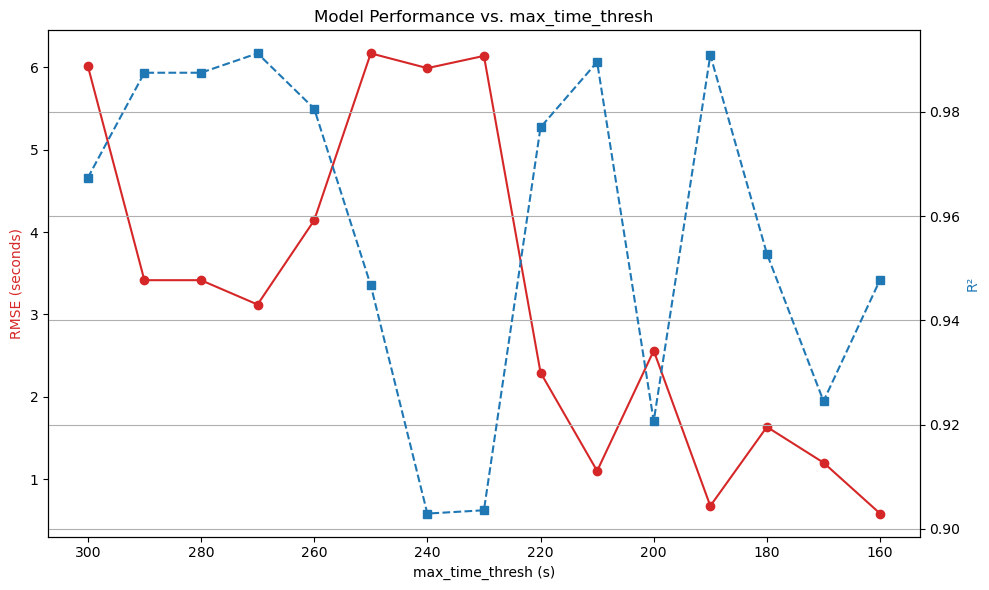

In [9]:
results = []
min_time_thresh = 110

# Sweep max_time_thresh from 500 down to 180 (step -10)
for max_time_thresh in tqdm(range(300, 150, -10)):
    df_filtered = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy()

    print(f"\nShape before outlier filtering: {df.shape}")
    print(f"min_time_thresh: {min_time_thresh}")
    print(f"max_time_thresh: {max_time_thresh}")
    print(f"Shape after outlier filtering: {df_filtered.shape}")

    if df_filtered.empty:
        print("⚠️ Skipping: no data left after filtering.")
        continue

    # Prepare features
    drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
    X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
    y = np.log1p(df_filtered[target])

    # Rebuild feature type lists dynamically (after drops)
    existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
    numeric_cols_current = [
        col for col in X.columns
        if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
    ]

    # Rebuild preprocessor dynamically for this subset
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols_current),
        ("cat", categorical_transformer, existing_categorical_cols)
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

    # Define model
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
    ])

    # --- Train ---
    model.fit(X_train, y_train)

    # --- Predict ---
    y_pred_log = model.predict(X_test)
    y_pred_sec = np.expm1(y_pred_log)
    y_test_sec = np.expm1(y_test)

    mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
    y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

    rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
    r2_sec = r2_score(y_test_sec, y_pred_sec)

    print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
    print(f"📊 R² (seconds): {r2_sec:.4f}")

    results.append({
        "max_time_thresh": max_time_thresh,
        "n_samples": len(df_filtered),
        "rmse_sec": rmse_sec,
        "r2_sec": r2_sec
    })

# --- Results Summary ---
res_df = pd.DataFrame(results)
print("\n=== Results Summary ===")
print(res_df.head())

# --- Plot Metrics vs. Threshold ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.plot(res_df["max_time_thresh"], res_df["rmse_sec"], "o-", color="tab:red", label="RMSE (s)")
ax2.plot(res_df["max_time_thresh"], res_df["r2_sec"], "s--", color="tab:blue", label="R²")

ax1.set_xlabel("max_time_thresh (s)")
ax1.set_ylabel("RMSE (seconds)", color="tab:red")
ax2.set_ylabel("R²", color="tab:blue")
plt.title("Model Performance vs. max_time_thresh")
ax1.invert_xaxis()  # Show decreasing thresholds left-to-right
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# Convert results to DataFrame
res_df = pd.DataFrame(results)

# Reorder columns for clarity
res_df = res_df[["max_time_thresh", "n_samples", "rmse_sec", "r2_sec"]]

print("\n=== Model Performance Across max_time_thresh ===")
print(res_df.to_string(index=False))


=== Model Performance Across max_time_thresh ===
 max_time_thresh  n_samples  rmse_sec   r2_sec
             300        536  6.021594 0.967330
             290        535  3.415857 0.987518
             280        535  3.415857 0.987518
             270        527  3.119918 0.991240
             260        516  4.141928 0.980639
             250        506  6.171563 0.946727
             240        492  5.991876 0.902907
             230        475  6.140515 0.903543
             220        460  2.293515 0.977034
             210        450  1.098490 0.989581
             200        435  2.558988 0.920640
             190        431  0.673263 0.990904
             180        426  1.633206 0.952769
             170        365  1.198946 0.924489
             160        288  0.580533 0.947789


## final models

### RA 110-290

In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

df = pd.read_parquet("road-america_all_races_lap_features.parquet")

# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
print("Advanced features created.")

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

best_params = {
    "model__n_estimators": 300, 
    "model__max_depth": 20, 
    "model__min_samples_leaf": 1,
    "model__max_features": 0.95,
    "model__min_samples_split": 2,
    "model__bootstrap": True,
    "model__criterion": "squared_error"
}
# {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 
    #'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

df_filtered = df[(df[target] > 110) & (df[target] < 290)].copy()

print(f"\nShape before outlier filtering: {df.shape}")
print(f"min_time_thresh: {min_time_thresh}")
print(f"max_time_thresh: {max_time_thresh}")
print(f"Shape after outlier filtering: {df_filtered.shape}")

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

# Prepare features
drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]

# Rebuild preprocessor dynamically for this subset
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols_current),
    ("cat", categorical_transformer, existing_categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

# Define model
model_road_america_overall = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
])

# --- Train ---
model_road_america_overall.fit(X_train, y_train)

# --- Predict ---
y_pred_log = model_road_america_overall.predict(X_test)
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print('rmse_sec:', rmse_sec)
print('r2_sec:', r2_sec)
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.

Shape before outlier filtering: (613, 77)
min_time_thresh: 75
max_time_thresh: 150
Shape after outlier filtering: (535, 77)
rmse_sec: 1.7014022638460757
r2_sec: 0.9969032568268796

--- Predicted Lap Times (Test Set) ---
count    107.000000
mean     176.809605
std       30.687172
min      151.819363
25%      154.716084
50%      169.203268
75%      175.093461
max      268.254467
dtype: float64


### RA for 110-190

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

df = pd.read_parquet("road-america_all_races_lap_features.parquet")

# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
print("Advanced features created.")

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

best_params = {
    "model__n_estimators": 200, 
    "model__max_depth": None, 
    "model__min_samples_leaf": 1,
    "model__max_features": 0.1,
    "model__min_samples_split": 2,
    "model__bootstrap": True,
    "model__criterion": "squared_error"
}
#{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 
    #'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

df_filtered = df[(df[target] > 110) & (df[target] < 190)].copy()

print(f"\nShape before outlier filtering: {df.shape}")
print(f"min_time_thresh: {min_time_thresh}")
print(f"max_time_thresh: {max_time_thresh}")
print(f"Shape after outlier filtering: {df_filtered.shape}")

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

# Prepare features
drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]

# Rebuild preprocessor dynamically for this subset
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols_current),
    ("cat", categorical_transformer, existing_categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

# Define model
model_road_america_specialist = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
])

# --- Train ---
model_road_america_specialist.fit(X_train, y_train)

# --- Predict ---
y_pred_log = model_road_america_specialist.predict(X_test)
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print('rmse_sec:', rmse_sec)
print('r2_sec:', r2_sec)
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.

Shape before outlier filtering: (613, 77)
min_time_thresh: 75
max_time_thresh: 150
Shape after outlier filtering: (431, 77)
rmse_sec: 0.6193598812466923
r2_sec: 0.9923021818758146

--- Predicted Lap Times (Test Set) ---
count     87.000000
mean     158.648324
std        6.892864
min      152.010583
25%      153.253687
50%      155.769153
75%      161.345972
max      172.976678
dtype: float64


# Circuit of the Americas

## Hyperparameter testing

Loaded shape: (1266, 72)
Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.
Shape before outlier filtering: (1221, 77)
min_time_thresh:  110
max_time_thresh:  170
Shape after outlier filtering: (808, 77)
✅ Using 69 numeric features.
✅ Using 5 categorical features: ['meta_session', 'original_vehicle_id', 'vehicle_number', 'vehicle_id', 'race_session']
Train shape: (646, 74), Test shape: (162, 74)

🔍 Starting Grid Search with 1296 combinations...
Using GroupKFold with 3 splits.


Grid Search Progress: 100%|████████████████████████████████████████████████████████| 1296/1296 [09:44<00:00,  2.22it/s]



✅ Best parameters:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🏁 Best CV MSE (log scale): 0.000088

📊 Final RMSE (log scale): 0.0042
📊 RMSE (seconds): 0.67
📊 R² (seconds): 0.9517

Top 20 Feature Importances:
num__mean_speed              0.302087
num__std_accy_can            0.109347
num__mean_nmot               0.083409
num__count_accx_can          0.043182
num__count_Steering_Angle    0.038015
num__std_nmot                0.034081
num__count_pbrake_f          0.031139
num__count_pbrake_r          0.029857
num__count_accy_can          0.026772
num__count_gear              0.024851
num__count_ath               0.024576
num__std_accx_can            0.021918
num__count_speed             0.015830
num__mean_ath                0.014415
num__count_nmot              0.013983
num__IM1a_time               0.012479
num__mean_pbrake_f           0.008911
num__mean_pbrake_r           0.00

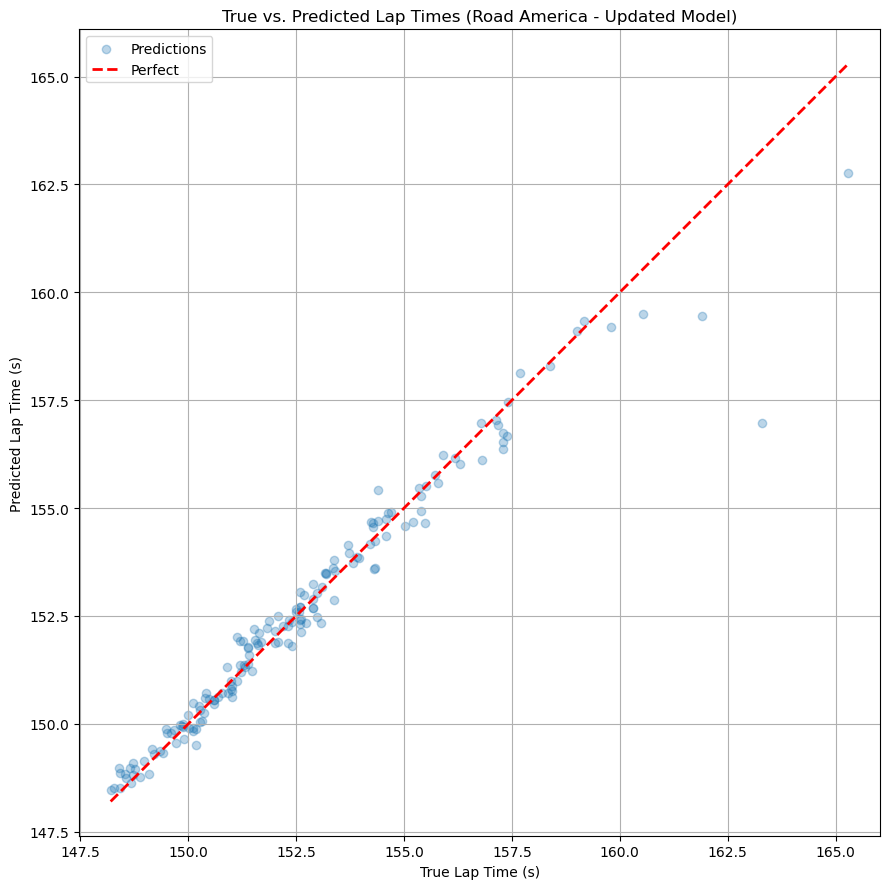

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load lap-level dataset ---
try:
    df = pd.read_parquet("circuit-of-the-americas_all_races_lap_features.parquet")
    print(f"Loaded shape: {df.shape}")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Ensure 'road-america_all_races_lap_features.parquet' is in the correct location.")
    exit() # Exit if file can't be loaded


# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
# Rename 'is_new_stint' to 'is_out_lap' for clarity (it marks the lap *after* a pit)
# Ensure it exists, fillna if not (though it should from process_race)
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)

# Get the in-pit flag (lap *entering* the pits)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)

# Define a 'normal' lap (not pitting, not leaving pits)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)

# Get the lap time only for normal laps, else NaN
#df['normal_lap_time'] = df[target].where(df['is_normal_lap'])
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))


# Forward-fill the last known normal lap time, then shift
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)

# Create a rolling average of the last 3 *normal* laps
# .reset_index(0, drop=True) is needed after a groupby().rolling()
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)

print("Advanced features created.")
# --- END NEW FEATURES ---


# --- 3. Define target, filter outliers, and define features (X) ---

# Filter outliers based on the original seconds scale *after* FE
print(f"Shape before outlier filtering: {df.shape}")
min_time_thresh = 110
max_time_thresh = 170

print('min_time_thresh: ', min_time_thresh)
print('max_time_thresh: ', max_time_thresh)
df = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy() # Use .copy()
print(f"Shape after outlier filtering: {df.shape}")

if df.empty:
    print("Error: No data remaining after outlier filtering. Check thresholds.")
    exit()

# Keep all features except lap index, the target, and intermediate columns
# The simple "last_lap_time" is no longer needed as we have better features
drop_cols = ["lap", target, 'normal_lap_time', 'last_lap_time']
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = np.log1p(df[target]) # Log transform the target


# --- 4. Identify feature types ---
categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

# Filter for columns that exist (safety)
existing_categorical_cols = [col for col in categorical_cols if col in X.columns]

# All others that are numeric
# This will now *automatically* include your new features:
# 'is_out_lap', 'pit_flag', 'is_normal_lap', 'last_normal_lap_time', 'rolling_3_normal_lap_avg'
numeric_cols = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]

print(f"✅ Using {len(numeric_cols)} numeric features.")
print(f"✅ Using {len(existing_categorical_cols)} categorical features: {existing_categorical_cols}")


# --- 5. Train/Test Split ---
# Note: X_masked and y_masked are no longer needed as we filtered 'df' directly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


# --- 6. Preprocessing and Model Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # 'mean' is fine, 'median' is also robust
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols), # Apply to numeric
        ('cat', categorical_transformer, existing_categorical_cols)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    #("model", LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1))
])

# --- 7. Define Hyperparameter Grid ---
# Using a slightly smaller, more focused grid based on your last results
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [300],
    "model__max_depth": [20],
    "model__max_features": [0.3, 0.5, "sqrt"],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [2],
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [100, 300, 500],                 # 100, 300, 500
    "model__max_depth": [1, 2, 3, 4, 5, 10, 20, 40, None],  # 1, 2, 3, 4, 5, 10, 20, 40, None
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],     # "sqrt", "log2", 0.3, 0.5
    "model__min_samples_split": [2, 5,10],          # 2, 5, 10
    "model__min_samples_leaf": [1, 2,4,8],            # 1, 2, 4, 8
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}
'''
param_grid = { #for LGBMRegressor
    "model__n_estimators": [300, 500],
    "model__learning_rate": [0.05, 0.1],     # How fast the model learns
    "model__num_leaves": [20, 31, 40],       # Key tuning parameter
    "model__max_depth": [20, -1],            # -1 means no limit
    "model__reg_alpha": [0, 0.1],            # L1 regularization
    "model__reg_lambda": [0, 0.1]            # L2 regularization
}
'''

# --- 8. Manual Grid Search with GroupKFold ---
param_combos = list(ParameterGrid(param_grid))
results = []
print(f"\n🔍 Starting Grid Search with {len(param_combos)} combinations...")

try:
    groups = X_train["vehicle_id"] if "vehicle_id" in X_train.columns else pd.Series(["unknown"] * len(X_train))
    # Ensure at least 3 unique groups for 3 splits, fallback to 2
    n_unique_groups = groups.nunique()
    n_splits = min(3, n_unique_groups)
    
    if n_splits < 2:
        print(f"⚠️ Only {n_unique_groups} unique group(s). Falling back to standard 3-fold CV (no grouping).")
        cv_split_method = 3
    else:
        print(f"Using GroupKFold with {n_splits} splits.")
        cv = GroupKFold(n_splits=n_splits)
        cv_split_method = list(cv.split(X_train, y_train, groups))

    for params in tqdm(param_combos, desc="Grid Search Progress"):
        full_pipeline.set_params(**params)
        scores = cross_val_score(
            full_pipeline,
            X_train,
            y_train,
            scoring="neg_mean_squared_error",
            cv=cv_split_method, # Use the defined split method
            n_jobs=-1
        )
        mean_mse = -np.mean(scores)
        results.append((params, mean_mse))

    best_params, best_mse = min(results, key=lambda x: x[1])
except Exception as e:
    print(f"⚠️ CV error: {e}. Defaulting to base parameters.")
    # Fallback parameters if grid search fails completely
    best_params = {
        "model__n_estimators": 300, 
        "model__max_depth": 20, 
        "model__min_samples_leaf": 2,
        "model__max_features": 0.3,
        "model__min_samples_split": 2,
        "model__bootstrap": True,
        "model__criterion": "squared_error"
    }
    best_mse = float('inf')

# --- 9. Final Training ---
print("\n✅ Best parameters:")
print({k.replace('model__', ''): v for k, v in best_params.items()})
print(f"🏁 Best CV MSE (log scale): {best_mse:.6f}") # More precision

full_pipeline.set_params(**best_params)
full_pipeline.fit(X_train, y_train)

# --- 10. Evaluate on test set ---
y_pred_log = full_pipeline.predict(X_test)
final_rmse_log = mean_squared_error(y_test, y_pred_log, squared=False)
print(f"\n📊 Final RMSE (log scale): {final_rmse_log:.4f}")

# Convert back to seconds
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

# Mask any potential inf/-inf from expm1
mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
print(f"📊 R² (seconds): {r2_sec:.4f}")

# --- 11. Feature Importances ---
try:
    feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = full_pipeline.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop 20 Feature Importances:")
    print(fi.head(20))
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

# --- 12. Visualization ---
plt.figure(figsize=(9, 9))
plt.scatter(y_test_sec, y_pred_sec, alpha=0.3, label='Predictions')
plt.plot([min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())],
         [min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())], 'r--', lw=2, label='Perfect')
plt.xlabel("True Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("True vs. Predicted Lap Times (Road America - Updated Model)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
#plt.savefig("road-america_model_true_vs_predicted_laps_final.png")
#print("✅ Plot saved: road-america_model_true_vs_predicted_laps_final.png")

# --- 13. Stats Comparison ---
print("\n--- True Lap Times (Test Set) ---")
print(pd.Series(y_test_sec).describe())
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

## Finding interval

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]


Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 300
Shape after outlier filtering: (1124, 77)


  6%|█████▏                                                                             | 1/16 [00:00<00:12,  1.19it/s]

📊 RMSE (seconds): 8.77
📊 R² (seconds): 0.9050

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 290
Shape after outlier filtering: (1124, 77)


 12%|██████████▍                                                                        | 2/16 [00:01<00:11,  1.20it/s]

📊 RMSE (seconds): 8.77
📊 R² (seconds): 0.9050

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 280
Shape after outlier filtering: (1121, 77)


 19%|███████████████▌                                                                   | 3/16 [00:02<00:10,  1.20it/s]

📊 RMSE (seconds): 12.76
📊 R² (seconds): 0.8348

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 270
Shape after outlier filtering: (1117, 77)


 25%|████████████████████▊                                                              | 4/16 [00:03<00:10,  1.19it/s]

📊 RMSE (seconds): 5.14
📊 R² (seconds): 0.9719

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 260
Shape after outlier filtering: (1113, 77)


 31%|█████████████████████████▉                                                         | 5/16 [00:04<00:09,  1.18it/s]

📊 RMSE (seconds): 7.33
📊 R² (seconds): 0.9268

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 250
Shape after outlier filtering: (1098, 77)


 38%|███████████████████████████████▏                                                   | 6/16 [00:05<00:08,  1.19it/s]

📊 RMSE (seconds): 3.32
📊 R² (seconds): 0.9850

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 240
Shape after outlier filtering: (1087, 77)


 44%|████████████████████████████████████▎                                              | 7/16 [00:05<00:07,  1.18it/s]

📊 RMSE (seconds): 4.33
📊 R² (seconds): 0.9739

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 230
Shape after outlier filtering: (1080, 77)


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:06<00:06,  1.20it/s]

📊 RMSE (seconds): 7.14
📊 R² (seconds): 0.9127

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 220
Shape after outlier filtering: (1035, 77)


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:07<00:05,  1.21it/s]

📊 RMSE (seconds): 4.71
📊 R² (seconds): 0.9561

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 210
Shape after outlier filtering: (917, 77)


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:08<00:04,  1.26it/s]

📊 RMSE (seconds): 2.61
📊 R² (seconds): 0.9680

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 200
Shape after outlier filtering: (864, 77)


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:08<00:03,  1.29it/s]

📊 RMSE (seconds): 2.46
📊 R² (seconds): 0.9514

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 190
Shape after outlier filtering: (822, 77)


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:09<00:02,  1.34it/s]

📊 RMSE (seconds): 1.31
📊 R² (seconds): 0.9026

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 180
Shape after outlier filtering: (816, 77)


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:10<00:02,  1.38it/s]

📊 RMSE (seconds): 0.62
📊 R² (seconds): 0.9686

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 170
Shape after outlier filtering: (808, 77)


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:11<00:01,  1.40it/s]

📊 RMSE (seconds): 0.54
📊 R² (seconds): 0.9682

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 160
Shape after outlier filtering: (784, 77)


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:11<00:00,  1.42it/s]

📊 RMSE (seconds): 0.48
📊 R² (seconds): 0.9606

Shape before outlier filtering: (1124, 77)
min_time_thresh: 110
max_time_thresh: 150
Shape after outlier filtering: (185, 77)


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]

📊 RMSE (seconds): 0.33
📊 R² (seconds): 0.6400

=== Results Summary ===
   max_time_thresh  n_samples   rmse_sec    r2_sec
0              300       1124   8.765401  0.904996
1              290       1124   8.765401  0.904996
2              280       1121  12.763880  0.834783
3              270       1117   5.141112  0.971852
4              260       1113   7.326741  0.926750


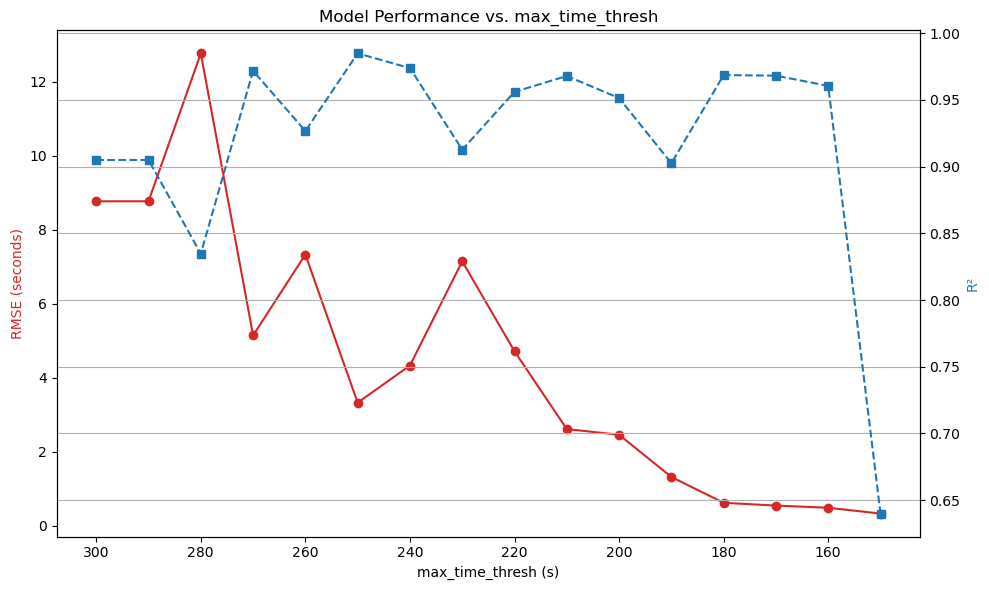

In [38]:
results = []
min_time_thresh = 110

# Sweep max_time_thresh from 500 down to 180 (step -10)
for max_time_thresh in tqdm(range(300, 140, -10)):
    df_filtered = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy()

    print(f"\nShape before outlier filtering: {df.shape}")
    print(f"min_time_thresh: {min_time_thresh}")
    print(f"max_time_thresh: {max_time_thresh}")
    print(f"Shape after outlier filtering: {df_filtered.shape}")

    if df_filtered.empty:
        print("⚠️ Skipping: no data left after filtering.")
        continue

    # Prepare features
    drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
    X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
    y = np.log1p(df_filtered[target])

    # Rebuild feature type lists dynamically (after drops)
    existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
    numeric_cols_current = [
        col for col in X.columns
        if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
    ]

    # Rebuild preprocessor dynamically for this subset
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols_current),
        ("cat", categorical_transformer, existing_categorical_cols)
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

    # Define model
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
    ])

    # --- Train ---
    model.fit(X_train, y_train)

    # --- Predict ---
    y_pred_log = model.predict(X_test)
    y_pred_sec = np.expm1(y_pred_log)
    y_test_sec = np.expm1(y_test)

    mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
    y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

    rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
    r2_sec = r2_score(y_test_sec, y_pred_sec)

    print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
    print(f"📊 R² (seconds): {r2_sec:.4f}")

    results.append({
        "max_time_thresh": max_time_thresh,
        "n_samples": len(df_filtered),
        "rmse_sec": rmse_sec,
        "r2_sec": r2_sec
    })

# --- Results Summary ---
res_df = pd.DataFrame(results)
print("\n=== Results Summary ===")
print(res_df.head())

# --- Plot Metrics vs. Threshold ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.plot(res_df["max_time_thresh"], res_df["rmse_sec"], "o-", color="tab:red", label="RMSE (s)")
ax2.plot(res_df["max_time_thresh"], res_df["r2_sec"], "s--", color="tab:blue", label="R²")

ax1.set_xlabel("max_time_thresh (s)")
ax1.set_ylabel("RMSE (seconds)", color="tab:red")
ax2.set_ylabel("R²", color="tab:blue")
plt.title("Model Performance vs. max_time_thresh")
ax1.invert_xaxis()  # Show decreasing thresholds left-to-right
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

# Convert results to DataFrame
res_df = pd.DataFrame(results)

# Reorder columns for clarity
res_df = res_df[["max_time_thresh", "n_samples", "rmse_sec", "r2_sec"]]

print("\n=== Model Performance Across max_time_thresh ===")
print(res_df.to_string(index=False))


=== Model Performance Across max_time_thresh ===
 max_time_thresh  n_samples  rmse_sec   r2_sec
             300       1124  8.765401 0.904996
             290       1124  8.765401 0.904996
             280       1121 12.763880 0.834783
             270       1117  5.141112 0.971852
             260       1113  7.326741 0.926750
             250       1098  3.322080 0.984958
             240       1087  4.326435 0.973893
             230       1080  7.142559 0.912723
             220       1035  4.711844 0.956065
             210        917  2.609215 0.967980
             200        864  2.455232 0.951413
             190        822  1.314464 0.902573
             180        816  0.616844 0.968644
             170        808  0.541065 0.968231
             160        784  0.482651 0.960559
             150        185  0.325461 0.639972


## COTA Final Models

### COTA 110-250

In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

df = pd.read_parquet("circuit-of-the-americas_all_races_lap_features.parquet")

# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
print("Advanced features created.")

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

best_params = {
    "model__n_estimators": 300, 
    "model__max_depth": 20, 
    "model__min_samples_leaf": 1,
    "model__max_features": 'sqrt',
    "model__min_samples_split": 5,
    "model__bootstrap": True,
    "model__criterion": "squared_error"
}
#{'bootstrap': True, 'criterion': 'squared_error', 
    #'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

df_filtered = df[(df[target] > 110) & (df[target] < 250)].copy()

print(f"\nShape before outlier filtering: {df.shape}")
print(f"min_time_thresh: {min_time_thresh}")
print(f"max_time_thresh: {max_time_thresh}")
print(f"Shape after outlier filtering: {df_filtered.shape}")

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

# Prepare features
drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]

# Rebuild preprocessor dynamically for this subset
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols_current),
    ("cat", categorical_transformer, existing_categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

# Define model
model_cota_overall = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
])

# --- Train ---
model_cota_overall.fit(X_train, y_train)

# --- Predict ---
y_pred_log = model_cota_overall.predict(X_test)
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print('rmse_sec:', rmse_sec)
print('r2_sec:', r2_sec)
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.

Shape before outlier filtering: (1221, 77)
min_time_thresh: 75
max_time_thresh: 150
Shape after outlier filtering: (1098, 77)
rmse_sec: 2.859862635855729
r2_sec: 0.9888528694274032

--- Predicted Lap Times (Test Set) ---
count    220.000000
mean     168.301172
std       26.086495
min      148.504944
25%      151.165347
50%      153.359907
75%      193.061615
max      240.532933
dtype: float64


### COTA 110-170

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

df = pd.read_parquet("circuit-of-the-americas_all_races_lap_features.parquet")

# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
print("Advanced features created.")

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

df_filtered = df[(df[target] > 110) & (df[target] < 170)].copy()

print(f"\nShape before outlier filtering: {df.shape}")
print(f"min_time_thresh: {min_time_thresh}")
print(f"max_time_thresh: {max_time_thresh}")
print(f"Shape after outlier filtering: {df_filtered.shape}")

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

# Prepare features
drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]

# Rebuild preprocessor dynamically for this subset
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols_current),
    ("cat", categorical_transformer, existing_categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_params = {
    "model__n_estimators": 300, 
    "model__max_depth": 20, 
    "model__min_samples_leaf": 1,
    "model__max_features": 0.9,
    "model__min_samples_split": 3,
    "model__bootstrap": True,
    "model__criterion": "squared_error"
} #{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 
    #'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

# Define model
model_cota_specialist = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
])

# --- Train ---
model_cota_specialist.fit(X_train, y_train)

# --- Predict ---
y_pred_log = model_cota_specialist.predict(X_test)
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print('rmse_sec:', rmse_sec)
print('r2_sec:', r2_sec)
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.

Shape before outlier filtering: (1221, 77)
min_time_thresh: 75
max_time_thresh: 150
Shape after outlier filtering: (808, 77)
rmse_sec: 0.48430185363010647
r2_sec: 0.974546957298683

--- Predicted Lap Times (Test Set) ---
count    162.000000
mean     152.621564
std        2.953247
min      148.401563
25%      150.343480
50%      152.126716
75%      154.155873
max      164.117883
dtype: float64


# barber-motorsports-park_all_races_lap_features

## Hyperparameter testing

Loaded shape: (1375, 92)
Starting feature engineering...
count    1375.000000
mean       82.772737
std        41.621199
min      -135.196000
25%        97.970500
50%        98.632000
75%        99.530000
max       322.439000
Name: lap_time_seconds, dtype: float64
Creating advanced stint and lag features...
Advanced features created.
Shape before outlier filtering: (1375, 92)
min_time_thresh:  80
max_time_thresh:  150
Shape after outlier filtering: (1118, 92)
✅ Using 9 numeric features.
✅ Using 5 categorical features: ['meta_session', 'original_vehicle_id', 'vehicle_number', 'vehicle_id', 'race_session']
Train shape: (894, 14), Test shape: (224, 14)

🔍 Starting Grid Search with 1296 combinations...
Using GroupKFold with 3 splits.


Grid Search Progress: 100%|████████████████████████████████████████████████████████| 1296/1296 [08:52<00:00,  2.43it/s]



✅ Best parameters:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
🏁 Best CV MSE (log scale): 0.000602

📊 Final RMSE (log scale): 0.0127
📊 RMSE (seconds): 1.33
📊 R² (seconds): 0.9610

Top 20 Feature Importances:
num__laps_on_tires                      0.378121
num__fuel_load_proxy                    0.143099
cat__meta_session_R2                    0.097402
num__rolling_3_normal_lap_avg           0.092418
cat__meta_session_R1                    0.092344
num__session_air_temp                   0.085390
num__last_normal_lap_time               0.056766
cat__vehicle_id_GR86-036-98             0.006343
cat__vehicle_number_98                  0.005063
cat__original_vehicle_id_GR86-036-98    0.004218
cat__vehicle_id_GR86-030-18             0.003329
cat__original_vehicle_id_GR86-030-18    0.003186
cat__vehicle_number_18                  0.003110
cat__vehicle_number_16                  0.

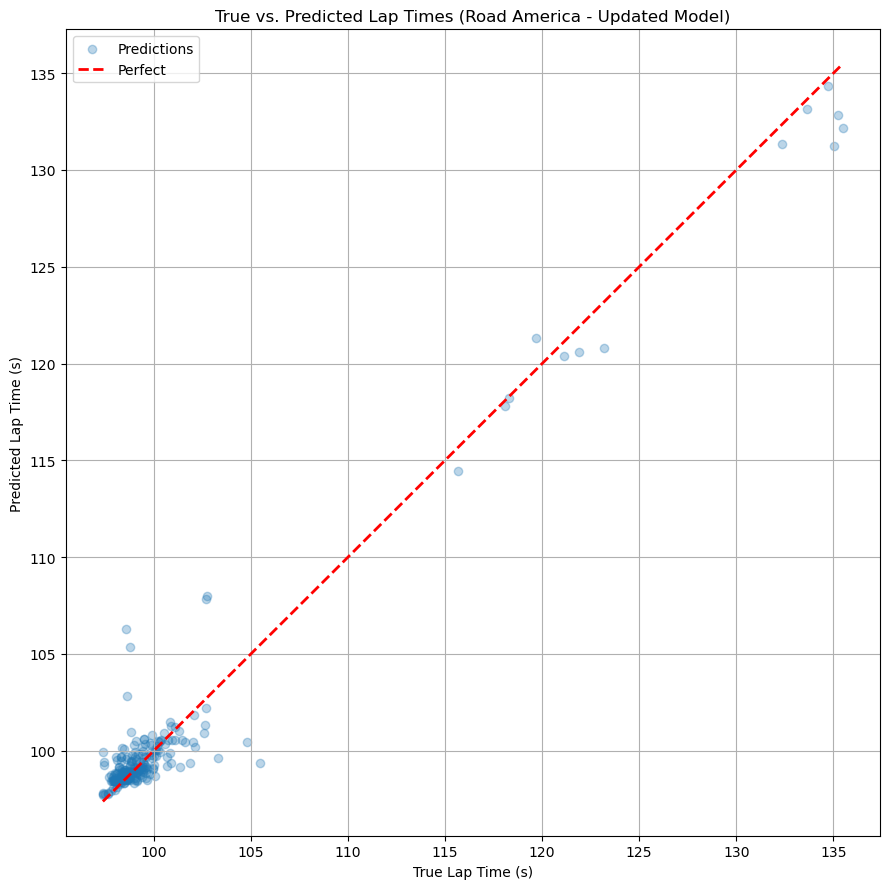

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load lap-level dataset ---
try:
    df = pd.read_parquet("barber_features_engineered.parquet")
    print(f"Loaded shape: {df.shape}")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Ensure 'road-america_all_races_lap_features.parquet' is in the correct location.")
    exit() # Exit if file can't be loaded


# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
#df[target] = df['lap_time_seconds'] / 1000.0
#print(pd.Series(y_test_sec).describe())
print(df[target].describe())

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
# Rename 'is_new_stint' to 'is_out_lap' for clarity (it marks the lap *after* a pit)
# Ensure it exists, fillna if not (though it should from process_race)
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)

# Get the in-pit flag (lap *entering* the pits)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)

# Define a 'normal' lap (not pitting, not leaving pits)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)

# Get the lap time only for normal laps, else NaN
#df['normal_lap_time'] = df[target].where(df['is_normal_lap'])
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))


# Forward-fill the last known normal lap time, then shift
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)

# Create a rolling average of the last 3 *normal* laps
# .reset_index(0, drop=True) is needed after a groupby().rolling()
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)

print("Advanced features created.")
# --- END NEW FEATURES ---


# --- 3. Define target, filter outliers, and define features (X) ---

# Filter outliers based on the original seconds scale *after* FE
print(f"Shape before outlier filtering: {df.shape}")
min_time_thresh = 80
max_time_thresh = 150

print('min_time_thresh: ', min_time_thresh)
print('max_time_thresh: ', max_time_thresh)
df = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy() # Use .copy()
print(f"Shape after outlier filtering: {df.shape}")

if df.empty:
    print("Error: No data remaining after outlier filtering. Check thresholds.")
    exit()

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

causal_numeric_cols = [
    'last_normal_lap_time',
    'rolling_3_normal_lap_avg',
    'laps_on_tires',
    'is_out_lap',
    'is_normal_lap',
    'pit_flag',
    'fuel_load_proxy',
    'session_air_temp',
    'session_track_temp'
]

df_filtered = df[(df[target] > 80) & (df[target] < 150)].copy()

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

causal_features_all = [col for col in (causal_numeric_cols + categorical_cols) if col in df_filtered.columns]

# Prepare features
#drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
#X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
X = df_filtered[causal_features_all].copy()
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
'''
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]
'''

numeric_cols = [c for c in causal_numeric_cols if c in X.columns]

print(f"✅ Using {len(numeric_cols)} numeric features.")
print(f"✅ Using {len(existing_categorical_cols)} categorical features: {existing_categorical_cols}")


# --- 5. Train/Test Split ---
# Note: X_masked and y_masked are no longer needed as we filtered 'df' directly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


# --- 6. Preprocessing and Model Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # 'mean' is fine, 'median' is also robust
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols), # Apply to numeric
        ('cat', categorical_transformer, existing_categorical_cols)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    #("model", LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1))
])

# --- 7. Define Hyperparameter Grid ---
# Using a slightly smaller, more focused grid based on your last results
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [300],
    "model__max_depth": [20],
    "model__max_features": [0.3, 0.5, "sqrt"],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [2],
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [100, 300, 500],                 # 100, 300, 500
    "model__max_depth": [1, 2, 3, 4, 5, 10, 20, 40, None],  # 1, 2, 3, 4, 5, 10, 20, 40, None
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],     # "sqrt", "log2", 0.3, 0.5
    "model__min_samples_split": [2, 5,10],          # 2, 5, 10
    "model__min_samples_leaf": [1, 2,4,8],            # 1, 2, 4, 8
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}

'''
param_grid = { #for LGBMRegressor
    "model__n_estimators": [300, 500],
    "model__learning_rate": [0.05, 0.1],     # How fast the model learns
    "model__num_leaves": [20, 31, 40],       # Key tuning parameter
    "model__max_depth": [20, -1],            # -1 means no limit
    "model__reg_alpha": [0, 0.1],            # L1 regularization
    "model__reg_lambda": [0, 0.1]            # L2 regularization
}
'''

# --- 8. Manual Grid Search with GroupKFold ---
param_combos = list(ParameterGrid(param_grid))
results = []
print(f"\n🔍 Starting Grid Search with {len(param_combos)} combinations...")

try:
    groups = X_train["vehicle_id"] if "vehicle_id" in X_train.columns else pd.Series(["unknown"] * len(X_train))
    # Ensure at least 3 unique groups for 3 splits, fallback to 2
    n_unique_groups = groups.nunique()
    n_splits = min(3, n_unique_groups)
    
    if n_splits < 2:
        print(f"⚠️ Only {n_unique_groups} unique group(s). Falling back to standard 3-fold CV (no grouping).")
        cv_split_method = 3
    else:
        print(f"Using GroupKFold with {n_splits} splits.")
        cv = GroupKFold(n_splits=n_splits)
        cv_split_method = list(cv.split(X_train, y_train, groups))

    for params in tqdm(param_combos, desc="Grid Search Progress"):
        full_pipeline.set_params(**params)
        scores = cross_val_score(
            full_pipeline,
            X_train,
            y_train,
            scoring="neg_mean_squared_error",
            cv=cv_split_method, # Use the defined split method
            n_jobs=-1
        )
        mean_mse = -np.mean(scores)
        results.append((params, mean_mse))

    best_params, best_mse = min(results, key=lambda x: x[1])
except Exception as e:
    print(f"⚠️ CV error: {e}. Defaulting to base parameters.")
    # Fallback parameters if grid search fails completely
    best_params = {
        "model__n_estimators": 300, 
        "model__max_depth": 20, 
        "model__min_samples_leaf": 2,
        "model__max_features": 0.3,
        "model__min_samples_split": 2,
        "model__bootstrap": True,
        "model__criterion": "squared_error"
    }
    best_mse = float('inf')

# --- 9. Final Training ---
print("\n✅ Best parameters:")
print({k.replace('model__', ''): v for k, v in best_params.items()})
print(f"🏁 Best CV MSE (log scale): {best_mse:.6f}") # More precision

full_pipeline.set_params(**best_params)
full_pipeline.fit(X_train, y_train)

# --- 10. Evaluate on test set ---
y_pred_log = full_pipeline.predict(X_test)
final_rmse_log = mean_squared_error(y_test, y_pred_log, squared=False)
print(f"\n📊 Final RMSE (log scale): {final_rmse_log:.4f}")

# Convert back to seconds
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

# Mask any potential inf/-inf from expm1
mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
print(f"📊 R² (seconds): {r2_sec:.4f}")

# --- 11. Feature Importances ---
try:
    feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = full_pipeline.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop 20 Feature Importances:")
    print(fi.head(20))
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

# --- 12. Visualization ---
plt.figure(figsize=(9, 9))
plt.scatter(y_test_sec, y_pred_sec, alpha=0.3, label='Predictions')
plt.plot([min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())],
         [min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())], 'r--', lw=2, label='Perfect')
plt.xlabel("True Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("True vs. Predicted Lap Times (Road America - Updated Model)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
#plt.savefig("road-america_model_true_vs_predicted_laps_final.png")
#print("✅ Plot saved: road-america_model_true_vs_predicted_laps_final.png")

# --- 13. Stats Comparison ---
print("\n--- True Lap Times (Test Set) ---")
print(pd.Series(y_test_sec).describe())
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

## Finding interval

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]


Shape before outlier filtering: (1118, 92)
min_time_thresh: 80
max_time_thresh: 150
Shape after outlier filtering: (1118, 92)


 17%|██████████████                                                                      | 1/6 [00:00<00:03,  1.36it/s]

📊 RMSE (seconds): 0.46
📊 R² (seconds): 0.9954

Shape before outlier filtering: (1118, 92)
min_time_thresh: 80
max_time_thresh: 140
Shape after outlier filtering: (1117, 92)


 33%|████████████████████████████                                                        | 2/6 [00:01<00:02,  1.38it/s]

📊 RMSE (seconds): 0.50
📊 R² (seconds): 0.9950

Shape before outlier filtering: (1118, 92)
min_time_thresh: 80
max_time_thresh: 130
Shape after outlier filtering: (1092, 92)


 50%|██████████████████████████████████████████                                          | 3/6 [00:02<00:02,  1.37it/s]

📊 RMSE (seconds): 0.47
📊 R² (seconds): 0.9782

Shape before outlier filtering: (1118, 92)
min_time_thresh: 80
max_time_thresh: 120
Shape after outlier filtering: (1082, 92)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:02<00:01,  1.42it/s]

📊 RMSE (seconds): 0.56
📊 R² (seconds): 0.9722

Shape before outlier filtering: (1118, 92)
min_time_thresh: 80
max_time_thresh: 110
Shape after outlier filtering: (1057, 92)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:03<00:00,  1.45it/s]

📊 RMSE (seconds): 0.39
📊 R² (seconds): 0.9441

Shape before outlier filtering: (1118, 92)
min_time_thresh: 80
max_time_thresh: 100
Shape after outlier filtering: (872, 92)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.49it/s]

📊 RMSE (seconds): 0.25
📊 R² (seconds): 0.8280

=== Results Summary ===
   max_time_thresh  n_samples  rmse_sec    r2_sec
0              150       1118  0.460048  0.995366
1              140       1117  0.502828  0.994956
2              130       1092  0.470957  0.978151
3              120       1082  0.563526  0.972196
4              110       1057  0.392118  0.944118


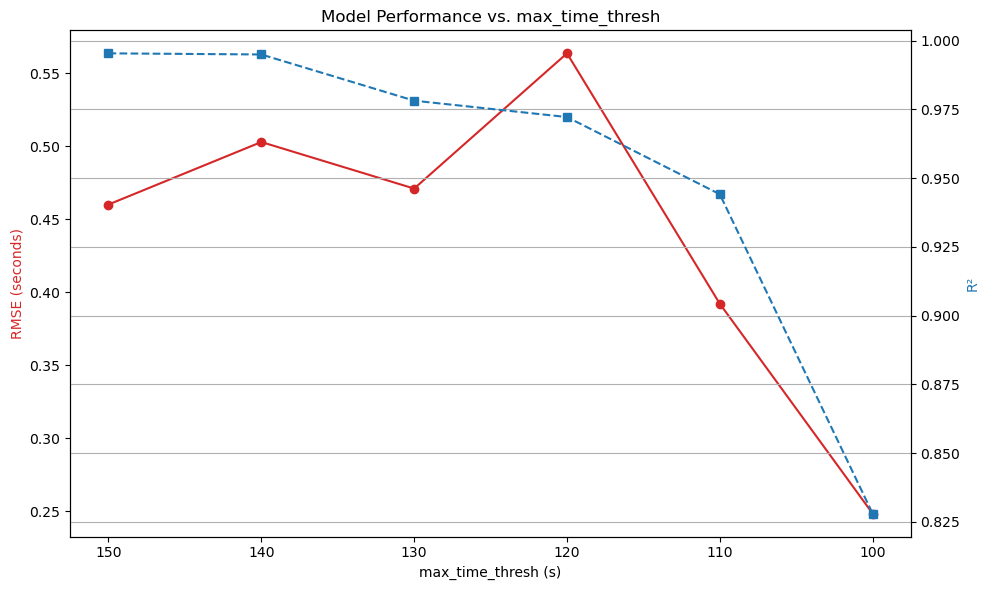

In [5]:
results = []
min_time_thresh = 80

# Sweep max_time_thresh from 500 down to 180 (step -10)
for max_time_thresh in tqdm(range(150, 90, -10)):
    df_filtered = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy()

    print(f"\nShape before outlier filtering: {df.shape}")
    print(f"min_time_thresh: {min_time_thresh}")
    print(f"max_time_thresh: {max_time_thresh}")
    print(f"Shape after outlier filtering: {df_filtered.shape}")

    if df_filtered.empty:
        print("⚠️ Skipping: no data left after filtering.")
        continue

    # Prepare features
    drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
    X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
    y = np.log1p(df_filtered[target])

    # Rebuild feature type lists dynamically (after drops)
    existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
    numeric_cols_current = [
        col for col in X.columns
        if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
    ]

    # Rebuild preprocessor dynamically for this subset
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols_current),
        ("cat", categorical_transformer, existing_categorical_cols)
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

    # Define model
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
    ])

    # --- Train ---
    model.fit(X_train, y_train)

    # --- Predict ---
    y_pred_log = model.predict(X_test)
    y_pred_sec = np.expm1(y_pred_log)
    y_test_sec = np.expm1(y_test)

    mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
    y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

    rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
    r2_sec = r2_score(y_test_sec, y_pred_sec)

    print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
    print(f"📊 R² (seconds): {r2_sec:.4f}")

    results.append({
        "max_time_thresh": max_time_thresh,
        "n_samples": len(df_filtered),
        "rmse_sec": rmse_sec,
        "r2_sec": r2_sec
    })

# --- Results Summary ---
res_df = pd.DataFrame(results)
print("\n=== Results Summary ===")
print(res_df.head())

# --- Plot Metrics vs. Threshold ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.plot(res_df["max_time_thresh"], res_df["rmse_sec"], "o-", color="tab:red", label="RMSE (s)")
ax2.plot(res_df["max_time_thresh"], res_df["r2_sec"], "s--", color="tab:blue", label="R²")

ax1.set_xlabel("max_time_thresh (s)")
ax1.set_ylabel("RMSE (seconds)", color="tab:red")
ax2.set_ylabel("R²", color="tab:blue")
plt.title("Model Performance vs. max_time_thresh")
ax1.invert_xaxis()  # Show decreasing thresholds left-to-right
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

# Convert results to DataFrame
res_df = pd.DataFrame(results)

# Reorder columns for clarity
res_df = res_df[["max_time_thresh", "n_samples", "rmse_sec", "r2_sec"]]

print("\n=== Model Performance Across max_time_thresh ===")
print(res_df.to_string(index=False))


=== Model Performance Across max_time_thresh ===
 max_time_thresh  n_samples  rmse_sec   r2_sec
             150       1118  0.460048 0.995366
             140       1117  0.502828 0.994956
             130       1092  0.470957 0.978151
             120       1082  0.563526 0.972196
             110       1057  0.392118 0.944118
             100        872  0.248499 0.827971


## Barber Final Model: [80, 150]

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

df = pd.read_parquet("barber_all_races_lap_features.parquet")

# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
#df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
print("Advanced features created.")

df.to_parquet('barber_features_engineered.parquet', index=False)

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

causal_numeric_cols = [
    'last_normal_lap_time',
    'rolling_3_normal_lap_avg',
    'laps_on_tires',
    'is_out_lap',
    'is_normal_lap',
    'pit_flag',
    'fuel_load_proxy',
    'session_air_temp',
    'session_track_temp'
]

df_filtered = df[(df[target] > 80) & (df[target] < 150)].copy()

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

causal_features_all = [col for col in (causal_numeric_cols + categorical_cols) if col in df_filtered.columns]

# Prepare features
#drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
#X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
X = df_filtered[causal_features_all].copy()
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
'''
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]
'''

numeric_cols_current = [c for c in causal_numeric_cols if c in X.columns]

# Rebuild preprocessor dynamically for this subset
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols_current),
    ("cat", categorical_transformer, existing_categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_params = {
    "model__n_estimators": 300, 
    "model__max_depth": 20, 
    "model__min_samples_leaf": 2,
    "model__max_features": 0.6,
    "model__min_samples_split": 2,
    "model__bootstrap": True,
    "model__criterion": "squared_error"
}
#best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 
    #'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#best parameters #2: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 
    #'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

# Define model
model_barber_overall = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
])

# --- Train ---
model_barber_overall.fit(X_train, y_train)

# --- Predict ---
y_pred_log = model_barber_overall.predict(X_test)
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print('rmse_sec:', rmse_sec)
print('r2_sec:', r2_sec)
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

dff = pd.read_parquet('barber_features_engineered.parquet')

# Filter for the specific race session and vehicle ID
race_session = "R2"
vehicle_id = "GR86-002-000"

subset = dff[(dff["meta_session"] == race_session) & (dff["vehicle_id"] == vehicle_id)]

# Show relevant columns
print(subset[["meta_session", "vehicle_id", "lap", "lap_time_seconds"]]
      .sort_values("lap")
      .reset_index(drop=True))

# --- 11. Feature Importances ---
try:
    # Get the final model step
    rf_model = model_barber_overall.named_steps['model']
    
    # Get the feature names from the preprocessor
    feature_names = model_barber_overall.named_steps['preprocessor'].get_feature_names_out()
    
    importances = rf_model.feature_importances_
    
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    print("\n--- Top 30 Feature Importances ---")
    print(fi.head(30))
    
    # --- CHECK FOR YOUR KEY FEATURES ---
    print("\n--- Key Simulation Feature Importance ---")
    if 'num__laps_on_tires' in fi:
        print(f"laps_on_tires: {fi['num__laps_on_tires']}")
    if 'num__fuel_load_proxy' in fi:
        print(f"fuel_load_proxy: {fi['num__fuel_load_proxy']}")
    if 'num__rolling_3_normal_lap_avg' in fi:
        print(f"rolling_3_normal_lap_avg: {fi['num__rolling_3_normal_lap_avg']}")
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

import joblib
joblib.dump(model_barber_overall, 'barber_overall_model.pkl')
print("Model saved to barber_overall_model.pkl")

Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.
rmse_sec: 1.1842539379206363
r2_sec: 0.9692916737351824

--- Predicted Lap Times (Test Set) ---
count    224.000000
mean     100.918011
std        6.496279
min       97.737261
25%       98.623985
50%       99.207439
75%      100.085605
max      134.625833
dtype: float64
   meta_session    vehicle_id  lap  lap_time_seconds
0            R2  GR86-002-000    2            99.977
1            R2  GR86-002-000    3            98.322
2            R2  GR86-002-000    4            98.169
3            R2  GR86-002-000    5            97.849
4            R2  GR86-002-000    6            98.433
5            R2  GR86-002-000    7            98.061
6            R2  GR86-002-000    8            98.563
7            R2  GR86-002-000    9            98.108
8            R2  GR86-002-000   10            98.415
9            R2  GR86-002-000   11            99.286
10           R2  GR86-002-000   12         

# sonoma

## Hyperparameter testing

Loaded shape: (967, 72)
Starting feature engineering...
count    881.000000
mean     126.860600
std       60.981541
min        0.000000
25%      129.376000
50%      130.793000
75%      135.001000
max      635.294000
Name: lap_time_seconds, dtype: float64
Creating advanced stint and lag features...
Advanced features created.
Shape before outlier filtering: (881, 77)
min_time_thresh:  75
max_time_thresh:  190
Shape after outlier filtering: (652, 77)
✅ Using 9 numeric features.
✅ Using 5 categorical features: ['meta_session', 'original_vehicle_id', 'vehicle_number', 'vehicle_id', 'race_session']
Train shape: (521, 14), Test shape: (131, 14)

🔍 Starting Grid Search with 108 combinations...
Using GroupKFold with 3 splits.


Grid Search Progress: 100%|██████████████████████████████████████████████████████████| 108/108 [00:43<00:00,  2.47it/s]



✅ Best parameters:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
🏁 Best CV MSE (log scale): 0.000330

📊 Final RMSE (log scale): 0.0143
📊 RMSE (seconds): 2.16
📊 R² (seconds): 0.9627

Top 20 Feature Importances:
num__laps_on_tires                       0.578377
num__fuel_load_proxy                     0.172943
num__last_normal_lap_time                0.096385
num__rolling_3_normal_lap_avg            0.042392
cat__vehicle_number_89                   0.013669
cat__vehicle_id_GR86-028-89              0.010817
cat__original_vehicle_id_GR86-028-89     0.008644
cat__original_vehicle_id_GR86-062-012    0.007634
cat__vehicle_number_12                   0.007018
cat__vehicle_id_GR86-062-012             0.006432
cat__vehicle_number_98                   0.005918
cat__original_vehicle_id_GR86-036-98     0.005874
cat__vehicle_id_GR86-036-98              0.005354
num__session_air_temp        

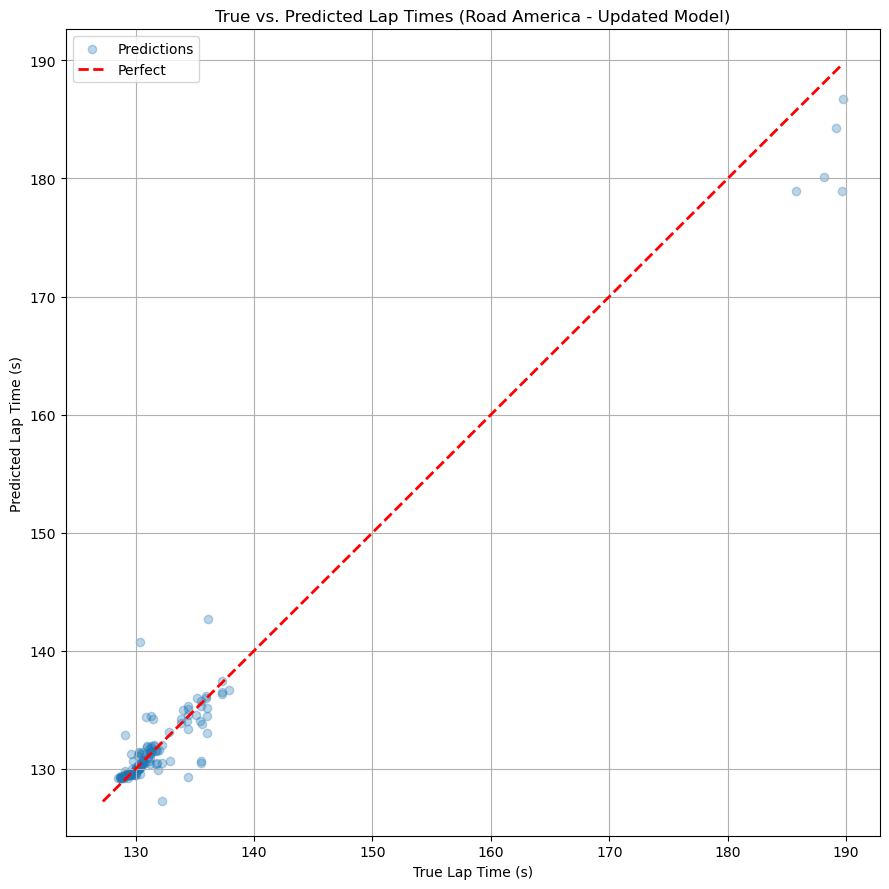

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load lap-level dataset ---
try:
    df = pd.read_parquet("virginia-international-raceway_all_races_lap_features.parquet")
    print(f"Loaded shape: {df.shape}")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Ensure 'road-america_all_races_lap_features.parquet' is in the correct location.")
    exit() # Exit if file can't be loaded


# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0
#print(pd.Series(y_test_sec).describe())
print(df[target].describe())

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
# Rename 'is_new_stint' to 'is_out_lap' for clarity (it marks the lap *after* a pit)
# Ensure it exists, fillna if not (though it should from process_race)
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)

# Get the in-pit flag (lap *entering* the pits)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)

# Define a 'normal' lap (not pitting, not leaving pits)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)

# Get the lap time only for normal laps, else NaN
#df['normal_lap_time'] = df[target].where(df['is_normal_lap'])
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))


# Forward-fill the last known normal lap time, then shift
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)

# Create a rolling average of the last 3 *normal* laps
# .reset_index(0, drop=True) is needed after a groupby().rolling()
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)

print("Advanced features created.")
# --- END NEW FEATURES ---


# --- 3. Define target, filter outliers, and define features (X) ---

# Filter outliers based on the original seconds scale *after* FE
print(f"Shape before outlier filtering: {df.shape}")
min_time_thresh = 75
max_time_thresh = 190

print('min_time_thresh: ', min_time_thresh)
print('max_time_thresh: ', max_time_thresh)
df = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy() # Use .copy()
print(f"Shape after outlier filtering: {df.shape}")

if df.empty:
    print("Error: No data remaining after outlier filtering. Check thresholds.")
    exit()

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

causal_numeric_cols = [
    'last_normal_lap_time',
    'rolling_3_normal_lap_avg',
    'laps_on_tires',
    'is_out_lap',
    'is_normal_lap',
    'pit_flag',
    'fuel_load_proxy',
    'session_air_temp',
    'session_track_temp'
]

df_filtered = df[(df[target] > 75) & (df[target] < 190)].copy()

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

causal_features_all = [col for col in (causal_numeric_cols + categorical_cols) if col in df_filtered.columns]

# Prepare features
#drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
#X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
X = df_filtered[causal_features_all].copy()
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
'''
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]
'''

numeric_cols = [c for c in causal_numeric_cols if c in X.columns]

print(f"✅ Using {len(numeric_cols)} numeric features.")
print(f"✅ Using {len(existing_categorical_cols)} categorical features: {existing_categorical_cols}")


# --- 5. Train/Test Split ---
# Note: X_masked and y_masked are no longer needed as we filtered 'df' directly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


# --- 6. Preprocessing and Model Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # 'mean' is fine, 'median' is also robust
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols), # Apply to numeric
        ('cat', categorical_transformer, existing_categorical_cols)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    #("model", LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1))
])

# --- 7. Define Hyperparameter Grid ---
# Using a slightly smaller, more focused grid based on your last results
'''
param_grid = { #for random forest regressor
    "model__n_estimators": [300],
    "model__max_depth": [20],
    "model__max_features": [0.3, 0.5, "sqrt"],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [2],
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}

'''
param_grid = { #for random forest regressor
    "model__n_estimators": [300],                 # 100, 300, 500
    "model__max_depth": [1, 2, 5, 10, 20, 40],  # 1, 2, 3, 4, 5, 10, 20, 40, None
    "model__max_features": ["sqrt", 0.3, 0.5],     # "sqrt", "log2", 0.3, 0.5
    "model__min_samples_split": [2, 5,10],          # 2, 5, 10
    "model__min_samples_leaf": [1, 2],            # 1, 2, 4, 8
    "model__bootstrap": [True],
    "model__criterion": ["squared_error"]
}
'''
param_grid = { #for LGBMRegressor
    "model__n_estimators": [300, 500],
    "model__learning_rate": [0.05, 0.1],     # How fast the model learns
    "model__num_leaves": [20, 31, 40],       # Key tuning parameter
    "model__max_depth": [20, -1],            # -1 means no limit
    "model__reg_alpha": [0, 0.1],            # L1 regularization
    "model__reg_lambda": [0, 0.1]            # L2 regularization
}
'''

# --- 8. Manual Grid Search with GroupKFold ---
param_combos = list(ParameterGrid(param_grid))
results = []
print(f"\n🔍 Starting Grid Search with {len(param_combos)} combinations...")

try:
    groups = X_train["vehicle_id"] if "vehicle_id" in X_train.columns else pd.Series(["unknown"] * len(X_train))
    # Ensure at least 3 unique groups for 3 splits, fallback to 2
    n_unique_groups = groups.nunique()
    n_splits = min(3, n_unique_groups)
    
    if n_splits < 2:
        print(f"⚠️ Only {n_unique_groups} unique group(s). Falling back to standard 3-fold CV (no grouping).")
        cv_split_method = 3
    else:
        print(f"Using GroupKFold with {n_splits} splits.")
        cv = GroupKFold(n_splits=n_splits)
        cv_split_method = list(cv.split(X_train, y_train, groups))

    for params in tqdm(param_combos, desc="Grid Search Progress"):
        full_pipeline.set_params(**params)
        scores = cross_val_score(
            full_pipeline,
            X_train,
            y_train,
            scoring="neg_mean_squared_error",
            cv=cv_split_method, # Use the defined split method
            n_jobs=-1
        )
        mean_mse = -np.mean(scores)
        results.append((params, mean_mse))

    best_params, best_mse = min(results, key=lambda x: x[1])
except Exception as e:
    print(f"⚠️ CV error: {e}. Defaulting to base parameters.")
    # Fallback parameters if grid search fails completely
    best_params = {
        "model__n_estimators": 300, 
        "model__max_depth": 20, 
        "model__min_samples_leaf": 2,
        "model__max_features": 0.3,
        "model__min_samples_split": 2,
        "model__bootstrap": True,
        "model__criterion": "squared_error"
    }
    best_mse = float('inf')

# --- 9. Final Training ---
print("\n✅ Best parameters:")
print({k.replace('model__', ''): v for k, v in best_params.items()})
print(f"🏁 Best CV MSE (log scale): {best_mse:.6f}") # More precision

full_pipeline.set_params(**best_params)
full_pipeline.fit(X_train, y_train)

# --- 10. Evaluate on test set ---
y_pred_log = full_pipeline.predict(X_test)
final_rmse_log = mean_squared_error(y_test, y_pred_log, squared=False)
print(f"\n📊 Final RMSE (log scale): {final_rmse_log:.4f}")

# Convert back to seconds
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

# Mask any potential inf/-inf from expm1
mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
print(f"📊 R² (seconds): {r2_sec:.4f}")

# --- 11. Feature Importances ---
try:
    feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = full_pipeline.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop 20 Feature Importances:")
    print(fi.head(20))
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

# --- 12. Visualization ---
plt.figure(figsize=(9, 9))
plt.scatter(y_test_sec, y_pred_sec, alpha=0.3, label='Predictions')
plt.plot([min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())],
         [min(y_test_sec.min(), y_pred_sec.min()), max(y_test_sec.max(), y_pred_sec.max())], 'r--', lw=2, label='Perfect')
plt.xlabel("True Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("True vs. Predicted Lap Times (Road America - Updated Model)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
#plt.savefig("road-america_model_true_vs_predicted_laps_final.png")
#print("✅ Plot saved: road-america_model_true_vs_predicted_laps_final.png")

# --- 13. Stats Comparison ---
print("\n--- True Lap Times (Test Set) ---")
print(pd.Series(y_test_sec).describe())
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

## Finding interval

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]


Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 600
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


  2%|█▋                                                                                 | 1/49 [00:00<00:17,  2.78it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 590
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


  4%|███▍                                                                               | 2/49 [00:00<00:16,  2.81it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 580
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


  6%|█████                                                                              | 3/49 [00:01<00:16,  2.80it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 570
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


  8%|██████▊                                                                            | 4/49 [00:01<00:16,  2.77it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 560
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 10%|████████▍                                                                          | 5/49 [00:01<00:15,  2.80it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 550
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 12%|██████████▏                                                                        | 6/49 [00:02<00:15,  2.81it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 540
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 14%|███████████▊                                                                       | 7/49 [00:02<00:14,  2.81it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 530
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 16%|█████████████▌                                                                     | 8/49 [00:02<00:14,  2.80it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 520
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 18%|███████████████▏                                                                   | 9/49 [00:03<00:14,  2.80it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 510
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 20%|████████████████▋                                                                 | 10/49 [00:03<00:13,  2.82it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 500
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 22%|██████████████████▍                                                               | 11/49 [00:03<00:13,  2.83it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 490
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 24%|████████████████████                                                              | 12/49 [00:04<00:13,  2.83it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 480
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 27%|█████████████████████▊                                                            | 13/49 [00:04<00:12,  2.83it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 470
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 29%|███████████████████████▍                                                          | 14/49 [00:04<00:12,  2.82it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 460
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 31%|█████████████████████████                                                         | 15/49 [00:05<00:12,  2.83it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 450
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 33%|██████████████████████████▊                                                       | 16/49 [00:05<00:11,  2.83it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 440
Shape after outlier filtering: (767, 77)
Train shape: (613, 14), Test shape: (154, 14)


 35%|████████████████████████████▍                                                     | 17/49 [00:06<00:11,  2.81it/s]

📊 RMSE (seconds): 7.71
📊 R² (seconds): 0.9234

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 430
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 37%|██████████████████████████████                                                    | 18/49 [00:06<00:11,  2.81it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 420
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 39%|███████████████████████████████▊                                                  | 19/49 [00:06<00:10,  2.83it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 410
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 41%|█████████████████████████████████▍                                                | 20/49 [00:07<00:10,  2.82it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 400
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 43%|███████████████████████████████████▏                                              | 21/49 [00:07<00:09,  2.82it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 390
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 45%|████████████████████████████████████▊                                             | 22/49 [00:07<00:09,  2.82it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 380
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 47%|██████████████████████████████████████▍                                           | 23/49 [00:08<00:09,  2.82it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 370
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 49%|████████████████████████████████████████▏                                         | 24/49 [00:08<00:08,  2.80it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 360
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 51%|█████████████████████████████████████████▊                                        | 25/49 [00:08<00:08,  2.80it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 350
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 53%|███████████████████████████████████████████▌                                      | 26/49 [00:09<00:08,  2.83it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 340
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 55%|█████████████████████████████████████████████▏                                    | 27/49 [00:09<00:07,  2.79it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 330
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 57%|██████████████████████████████████████████████▊                                   | 28/49 [00:09<00:07,  2.80it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 320
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 59%|████████████████████████████████████████████████▌                                 | 29/49 [00:10<00:07,  2.82it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 310
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 61%|██████████████████████████████████████████████████▏                               | 30/49 [00:10<00:06,  2.75it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 300
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 63%|███████████████████████████████████████████████████▉                              | 31/49 [00:11<00:06,  2.77it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 290
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [00:11<00:06,  2.79it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 280
Shape after outlier filtering: (765, 77)
Train shape: (612, 14), Test shape: (153, 14)


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [00:11<00:05,  2.81it/s]

📊 RMSE (seconds): 8.82
📊 R² (seconds): 0.8969

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 270
Shape after outlier filtering: (763, 77)
Train shape: (610, 14), Test shape: (153, 14)


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [00:12<00:05,  2.82it/s]

📊 RMSE (seconds): 9.26
📊 R² (seconds): 0.8814

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 260
Shape after outlier filtering: (763, 77)
Train shape: (610, 14), Test shape: (153, 14)


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [00:12<00:04,  2.84it/s]

📊 RMSE (seconds): 9.26
📊 R² (seconds): 0.8814

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 250
Shape after outlier filtering: (763, 77)
Train shape: (610, 14), Test shape: (153, 14)


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [00:12<00:04,  2.84it/s]

📊 RMSE (seconds): 9.26
📊 R² (seconds): 0.8814

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 240
Shape after outlier filtering: (763, 77)
Train shape: (610, 14), Test shape: (153, 14)


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [00:13<00:04,  2.84it/s]

📊 RMSE (seconds): 9.26
📊 R² (seconds): 0.8814

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 230
Shape after outlier filtering: (763, 77)
Train shape: (610, 14), Test shape: (153, 14)


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [00:13<00:03,  2.85it/s]

📊 RMSE (seconds): 9.26
📊 R² (seconds): 0.8814

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 220
Shape after outlier filtering: (759, 77)
Train shape: (607, 14), Test shape: (152, 14)


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [00:13<00:03,  2.85it/s]

📊 RMSE (seconds): 4.23
📊 R² (seconds): 0.9724

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 210
Shape after outlier filtering: (755, 77)
Train shape: (604, 14), Test shape: (151, 14)


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [00:14<00:03,  2.86it/s]

📊 RMSE (seconds): 4.18
📊 R² (seconds): 0.9750

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 200
Shape after outlier filtering: (706, 77)
Train shape: (564, 14), Test shape: (142, 14)


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [00:14<00:02,  2.86it/s]

📊 RMSE (seconds): 3.71
📊 R² (seconds): 0.9593

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 190
Shape after outlier filtering: (652, 77)
Train shape: (521, 14), Test shape: (131, 14)


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [00:14<00:02,  2.86it/s]

📊 RMSE (seconds): 2.11
📊 R² (seconds): 0.9644

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 180
Shape after outlier filtering: (638, 77)
Train shape: (510, 14), Test shape: (128, 14)


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [00:15<00:02,  2.88it/s]

📊 RMSE (seconds): 2.69
📊 R² (seconds): 0.4317

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 170
Shape after outlier filtering: (638, 77)
Train shape: (510, 14), Test shape: (128, 14)


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [00:15<00:01,  2.88it/s]

📊 RMSE (seconds): 2.69
📊 R² (seconds): 0.4317

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 160
Shape after outlier filtering: (638, 77)
Train shape: (510, 14), Test shape: (128, 14)


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [00:15<00:01,  2.88it/s]

📊 RMSE (seconds): 2.69
📊 R² (seconds): 0.4317

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 150
Shape after outlier filtering: (638, 77)
Train shape: (510, 14), Test shape: (128, 14)


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [00:16<00:01,  2.88it/s]

📊 RMSE (seconds): 2.69
📊 R² (seconds): 0.4317

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 140
Shape after outlier filtering: (628, 77)
Train shape: (502, 14), Test shape: (126, 14)


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [00:16<00:00,  2.88it/s]

📊 RMSE (seconds): 1.24
📊 R² (seconds): 0.7642

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 130
Shape after outlier filtering: (209, 77)
Train shape: (167, 14), Test shape: (42, 14)


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [00:16<00:00,  2.93it/s]

📊 RMSE (seconds): 0.33
📊 R² (seconds): 0.3112

Shape before outlier filtering: (767, 77)
min_time_thresh: 75
max_time_thresh: 120
Shape after outlier filtering: (2, 77)
Train shape: (1, 14), Test shape: (1, 14)


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:17<00:00,  2.84it/s]

📊 RMSE (seconds): 0.00
📊 R² (seconds): nan

=== Results Summary ===
   max_time_thresh  n_samples  rmse_sec    r2_sec
0              600        767  7.706945  0.923383
1              590        767  7.706945  0.923383
2              580        767  7.706945  0.923383
3              570        767  7.706945  0.923383
4              560        767  7.706945  0.923383


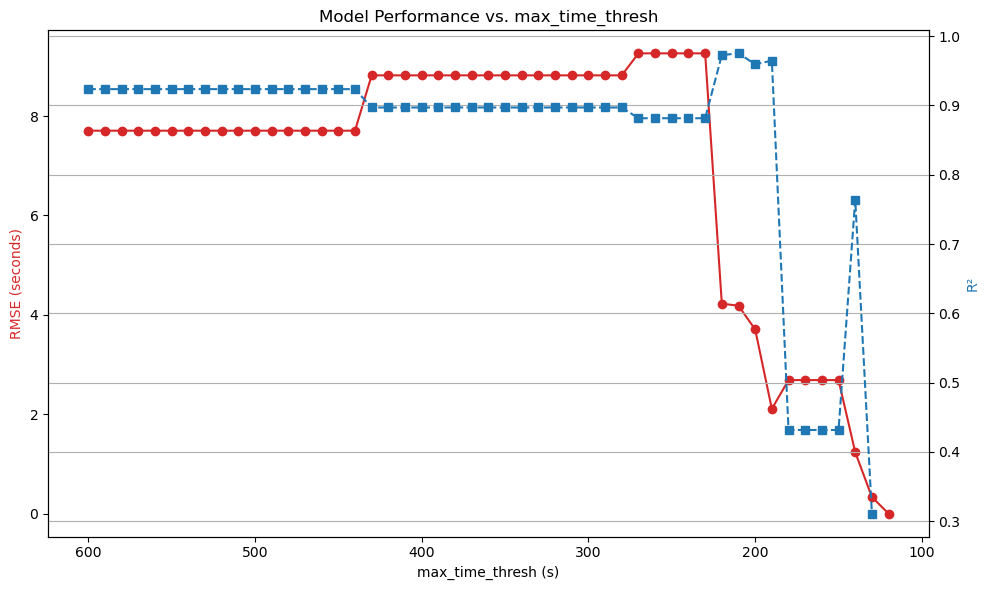

In [3]:
results = []
min_time_thresh = 75

# Sweep max_time_thresh from 500 down to 180 (step -10)
for max_time_thresh in tqdm(range(600, 110, -10)):
    df_filtered = df[(df[target] > min_time_thresh) & (df[target] < max_time_thresh)].copy()

    print(f"\nShape before outlier filtering: {df.shape}")
    print(f"min_time_thresh: {min_time_thresh}")
    print(f"max_time_thresh: {max_time_thresh}")
    print(f"Shape after outlier filtering: {df_filtered.shape}")

    if df_filtered.empty:
        print("⚠️ Skipping: no data left after filtering.")
        continue

    # Prepare features
    drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
    X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
    y = np.log1p(df_filtered[target])

    # Prepare features
    #drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
    #X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
    X = df_filtered[causal_features_all].copy()
    y = np.log1p(df_filtered[target])
    
    # Rebuild feature type lists dynamically (after drops)
    existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
    '''
    numeric_cols_current = [
        col for col in X.columns
        if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
    ]
    '''

    numeric_cols = [c for c in causal_numeric_cols if c in X.columns]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    
    # --- 6. Preprocessing and Model Pipeline ---
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')), # 'mean' is fine, 'median' is also robust
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols), # Apply to numeric
            ('cat', categorical_transformer, existing_categorical_cols)
        ],
        remainder='passthrough'
    )
    
    full_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
        #("model", LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1))
    ])

    cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

    # Define model
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
    ])

    # --- Train ---
    model.fit(X_train, y_train)

    # --- Predict ---
    y_pred_log = model.predict(X_test)
    y_pred_sec = np.expm1(y_pred_log)
    y_test_sec = np.expm1(y_test)

    mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
    y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

    rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
    r2_sec = r2_score(y_test_sec, y_pred_sec)

    print(f"📊 RMSE (seconds): {rmse_sec:.2f}")
    print(f"📊 R² (seconds): {r2_sec:.4f}")

    results.append({
        "max_time_thresh": max_time_thresh,
        "n_samples": len(df_filtered),
        "rmse_sec": rmse_sec,
        "r2_sec": r2_sec
    })

# --- Results Summary ---
res_df = pd.DataFrame(results)
print("\n=== Results Summary ===")
print(res_df.head())

# --- Plot Metrics vs. Threshold ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.plot(res_df["max_time_thresh"], res_df["rmse_sec"], "o-", color="tab:red", label="RMSE (s)")
ax2.plot(res_df["max_time_thresh"], res_df["r2_sec"], "s--", color="tab:blue", label="R²")

ax1.set_xlabel("max_time_thresh (s)")
ax1.set_ylabel("RMSE (seconds)", color="tab:red")
ax2.set_ylabel("R²", color="tab:blue")
plt.title("Model Performance vs. max_time_thresh")
ax1.invert_xaxis()  # Show decreasing thresholds left-to-right
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

# Convert results to DataFrame
res_df = pd.DataFrame(results)

# Reorder columns for clarity
res_df = res_df[["max_time_thresh", "n_samples", "rmse_sec", "r2_sec"]]

print("\n=== Model Performance Across max_time_thresh ===")
print(res_df.to_string(index=False))


=== Model Performance Across max_time_thresh ===
 max_time_thresh  n_samples     rmse_sec   r2_sec
             600        767 7.706945e+00 0.923383
             590        767 7.706945e+00 0.923383
             580        767 7.706945e+00 0.923383
             570        767 7.706945e+00 0.923383
             560        767 7.706945e+00 0.923383
             550        767 7.706945e+00 0.923383
             540        767 7.706945e+00 0.923383
             530        767 7.706945e+00 0.923383
             520        767 7.706945e+00 0.923383
             510        767 7.706945e+00 0.923383
             500        767 7.706945e+00 0.923383
             490        767 7.706945e+00 0.923383
             480        767 7.706945e+00 0.923383
             470        767 7.706945e+00 0.923383
             460        767 7.706945e+00 0.923383
             450        767 7.706945e+00 0.923383
             440        767 7.706945e+00 0.923383
             430        765 8.820694e+00 0.896912


## Final Sonoma Model

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt # Import for plotting
import warnings

df = pd.read_parquet("virginia-international-raceway_all_races_lap_features.parquet")

# Drop rows without target
df = df.dropna(subset=["lap_time_seconds"])

# --- 2. Advanced Feature Engineering ---
print("Starting feature engineering...")
df = df.sort_values(by=["vehicle_id", "lap"])

target = "lap_time_seconds"
df[target] = df['lap_time_seconds'] / 1000.0

# --- NEW: Advanced Lag & Stint Features ---
print("Creating advanced stint and lag features...")
df['is_out_lap'] = df['is_new_stint'].fillna(0).astype(int)
df['pit_flag'] = df['CROSSING_FINISH_LINE_IN_PIT'].fillna(0).astype(int)
df['is_normal_lap'] = ((df['pit_flag'] == 0) & (df['is_out_lap'] == 0)).astype(int)
df['normal_lap_time'] = df[target].where(df['is_normal_lap'].astype(bool))
df['last_normal_lap_time'] = df.groupby('vehicle_id')['normal_lap_time'].ffill().shift(1)
df['rolling_3_normal_lap_avg'] = df.groupby('vehicle_id')['last_normal_lap_time'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
print("Advanced features created.")

df.to_parquet('virginia_international_raceway_features_engineered.parquet', index=False)

categorical_cols = [
    "meta_session",
    "original_vehicle_id",
    "vehicle_number",
    "vehicle_id",
    "race_session"
]

causal_numeric_cols = [
    'last_normal_lap_time',
    'rolling_3_normal_lap_avg',
    'laps_on_tires',
    'is_out_lap',
    'is_normal_lap',
    'pit_flag',
    'fuel_load_proxy',
    'session_air_temp',
    'session_track_temp'
]

df_filtered = df[(df[target] > 75) & (df[target] < 190)].copy()

if df_filtered.empty:
    print("⚠️ Skipping: no data left after filtering.")

causal_features_all = [col for col in (causal_numeric_cols + categorical_cols) if col in df_filtered.columns]

# Prepare features
#drop_cols = ["lap", target, "normal_lap_time", "last_lap_time"]
#X = df_filtered.drop(columns=[c for c in drop_cols if c in df_filtered.columns])
X = df_filtered[causal_features_all].copy()
y = np.log1p(df_filtered[target])

# Rebuild feature type lists dynamically (after drops)
existing_categorical_cols = [c for c in categorical_cols if c in X.columns]
'''
numeric_cols_current = [
    col for col in X.columns
    if col not in existing_categorical_cols and pd.api.types.is_numeric_dtype(X[col])
]
'''

numeric_cols_current = [c for c in causal_numeric_cols if c in X.columns]

# Rebuild preprocessor dynamically for this subset
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols_current),
    ("cat", categorical_transformer, existing_categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_params = {
    "model__n_estimators": 350, 
    "model__max_depth": 5, 
    "model__min_samples_leaf": 1,
    "model__max_features": 0.8,
    "model__min_samples_split": 2,
    "model__bootstrap": True,
    "model__criterion": "squared_error"
}
#'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

cleaned_params = {k.split("__")[-1]: v for k, v in best_params.items()}

# Define model
model_virginia_international_raceway_overall = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **cleaned_params))
])

# --- Train ---
model_virginia_international_raceway_overall.fit(X_train, y_train)

# --- Predict ---
y_pred_log = model_virginia_international_raceway_overall.predict(X_test)
y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

mask = np.isfinite(y_pred_sec) & np.isfinite(y_test_sec)
y_pred_sec, y_test_sec = y_pred_sec[mask], y_test_sec[mask]

rmse_sec = mean_squared_error(y_test_sec, y_pred_sec, squared=False)
r2_sec = r2_score(y_test_sec, y_pred_sec)
print('rmse_sec:', rmse_sec)
print('r2_sec:', r2_sec)
print("\n--- Predicted Lap Times (Test Set) ---")
print(pd.Series(y_pred_sec).describe())

# --- 11. Feature Importances ---
try:
    # Get the final model step
    rf_model = model_virginia_international_raceway_overall.named_steps['model']
    
    # Get the feature names from the preprocessor
    feature_names = model_virginia_international_raceway_overall.named_steps['preprocessor'].get_feature_names_out()
    
    importances = rf_model.feature_importances_
    
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    print("\n--- Top 30 Feature Importances ---")
    print(fi.head(30))
    
    # --- CHECK FOR YOUR KEY FEATURES ---
    print("\n--- Key Simulation Feature Importance ---")
    if 'num__laps_on_tires' in fi:
        print(f"laps_on_tires: {fi['num__laps_on_tires']}")
    if 'num__fuel_load_proxy' in fi:
        print(f"fuel_load_proxy: {fi['num__fuel_load_proxy']}")
    if 'num__rolling_3_normal_lap_avg' in fi:
        print(f"rolling_3_normal_lap_avg: {fi['num__rolling_3_normal_lap_avg']}")
except Exception as e:
    print(f"Feature importance retrieval failed: {e}")

import joblib
joblib.dump(model_virginia_international_raceway_overall, 'model_virginia_international_raceway_overall.pkl')
print("Model saved to model_virginia_international_raceway_overall.pkl")

Starting feature engineering...
Creating advanced stint and lag features...
Advanced features created.
rmse_sec: 1.5184437135691418
r2_sec: 0.9815225622476138

--- Predicted Lap Times (Test Set) ---
count    131.000000
mean     133.595169
std       10.956254
min      129.176404
25%      129.954272
50%      130.326532
75%      133.636760
max      188.187296
dtype: float64

--- Top 30 Feature Importances ---
num__laps_on_tires                       0.754198
num__last_normal_lap_time                0.101090
num__fuel_load_proxy                     0.085570
num__rolling_3_normal_lap_avg            0.014480
cat__vehicle_number_98                   0.006073
cat__original_vehicle_id_GR86-036-98     0.006025
cat__vehicle_id_GR86-036-98              0.004900
cat__original_vehicle_id_GR86-028-89     0.004123
cat__vehicle_number_89                   0.003136
cat__vehicle_id_GR86-028-89              0.002537
cat__vehicle_number_12                   0.002387
cat__vehicle_id_GR86-062-012            